In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install colorama


In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heart-attack-analysis-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1226038%2F2047221%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240223%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240223T093459Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da4764d69cc7c037ea3292eebabea41c61b8c57c2f0ae5106b6d7178971911ba3484ea04fa769cb2b7ba3c5c524b67df12f030b9397715ea55b6b081a0ca2db0c0aecd78dddae509e930935a71a8ff5bd17e7dfcaa8a5e4537365d9c1f09da83cd3efd0fc554ce194aeafc7798aacac82c425d655ab5ba76717c77fc2b3608655863b8b42bbac40206464c099f6c757fcc31d93c8fdc549ee4fcbc96c5368ceaea5f01579a7e0f2bf43983cb8ab27e4f7b2fed0caa61fc34f216e69488a54b02d63ea6eca84c0db2e852d435cfd9cee25caf993b5250b84933bf948c870e081d520a0634add9c813d4e749ba343b5d86cbe0207d7fc5779cef07a58496ec789d2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4209 bytes downloaded
Downloaded and uncompressed: heart-attack-analysis-prediction-dataset
Data source import complete.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import colorama
from colorama import Back
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [ ]:
Main_Dataset = pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')
Main_Dataset = pd.DataFrame(Main_Dataset)

In [ ]:
print(Main_Dataset.shape)
Main_Dataset.head(10).style.set_properties(**{'background-color': '#F6E7E8',
                           'color': 'black',
                           'border-color': 'black'})

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.300000,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.500000,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.400000,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.800000,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.600000,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.400000,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.300000,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.000000,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.500000,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.600000,2,0,2,1


In [ ]:
def describe(Main_Dataset):


    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    min_ = []
    max_ = []


    for item in Main_Dataset.columns:
        variables.append(item)
        dtypes.append(Main_Dataset[item].dtype)
        count.append(len(Main_Dataset[item]))
        unique.append(len(Main_Dataset[item].unique()))
        missing.append(Main_Dataset[item].isna().sum())

        if Main_Dataset[item].dtypes == 'float64' or Main_Dataset[item].dtypes == 'int64':
            min_.append(Main_Dataset[item].min())
            max_.append(Main_Dataset[item].max())
        else:
            min_.append('Str')
            max_.append('Str')


    output = pd.DataFrame({
        'variable': variables,
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing value': missing,
        'Min': min_,
        'Max': max_
    })

    return output

In [ ]:
Styles = [dict(selector = "caption",
               props = [("color", "white"),
                        ("text-align", "center"),
                       ('font-size', '15pt'),
                       ('background-color', '#E72B3B')])]

In [ ]:
desc_df = describe(Main_Dataset)
desc_df = desc_df.style.set_caption('Overview of the dataset').set_table_styles(Styles)
desc_df.set_properties(**{'background-color': '#F6E7E8',
                           'color': 'black',
                           'border-color': 'black'})

,variable,dtype,count,unique,missing value,Min,Max
0,age,int64,303,41,0,29.000000,77.000000
1,sex,int64,303,2,0,0.000000,1.000000
2,cp,int64,303,4,0,0.000000,3.000000
3,trtbps,int64,303,49,0,94.000000,200.000000
4,chol,int64,303,152,0,126.000000,564.000000
5,fbs,int64,303,2,0,0.000000,1.000000
6,restecg,int64,303,3,0,0.000000,2.000000
7,thalachh,int64,303,91,0,71.000000,202.000000
8,exng,int64,303,2,0,0.000000,1.000000
9,oldpeak,float64,303,40,0,0.000000,6.200000


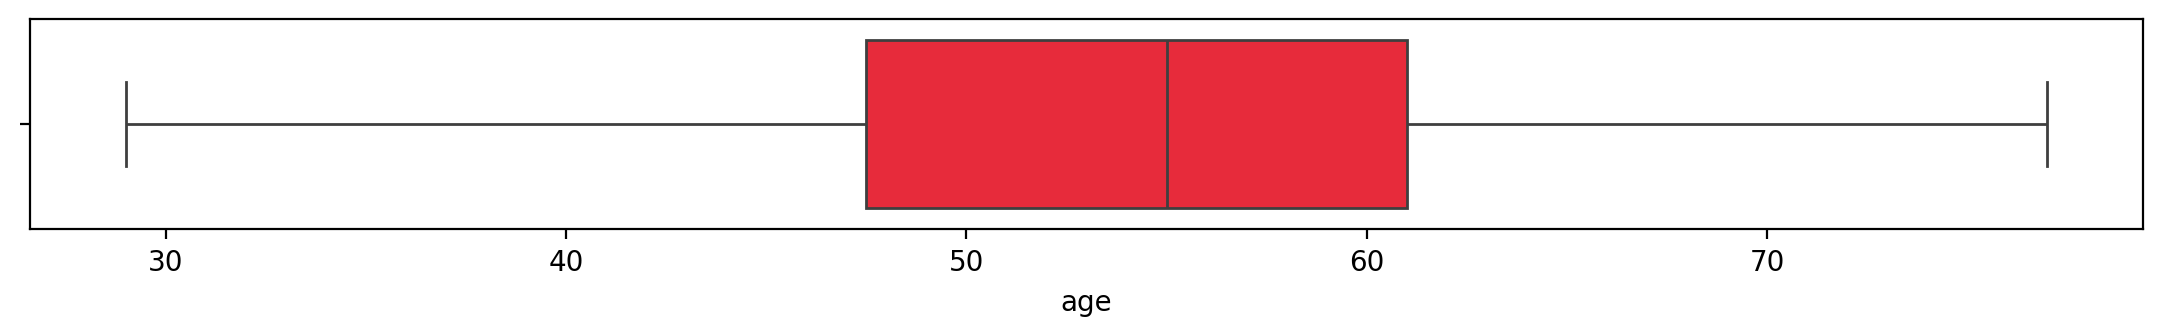

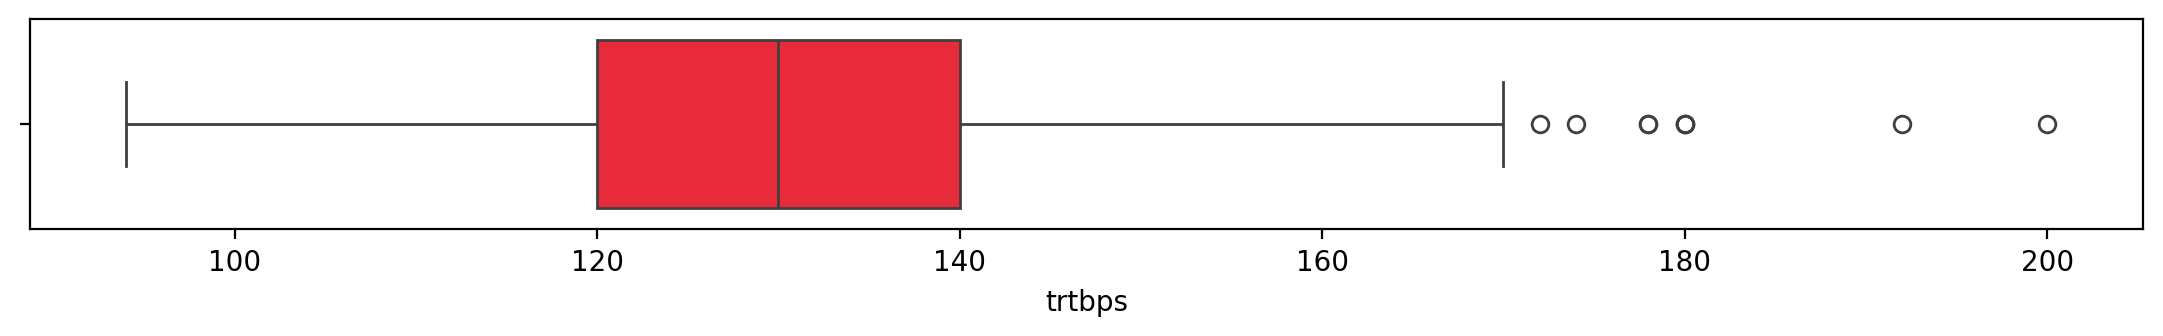

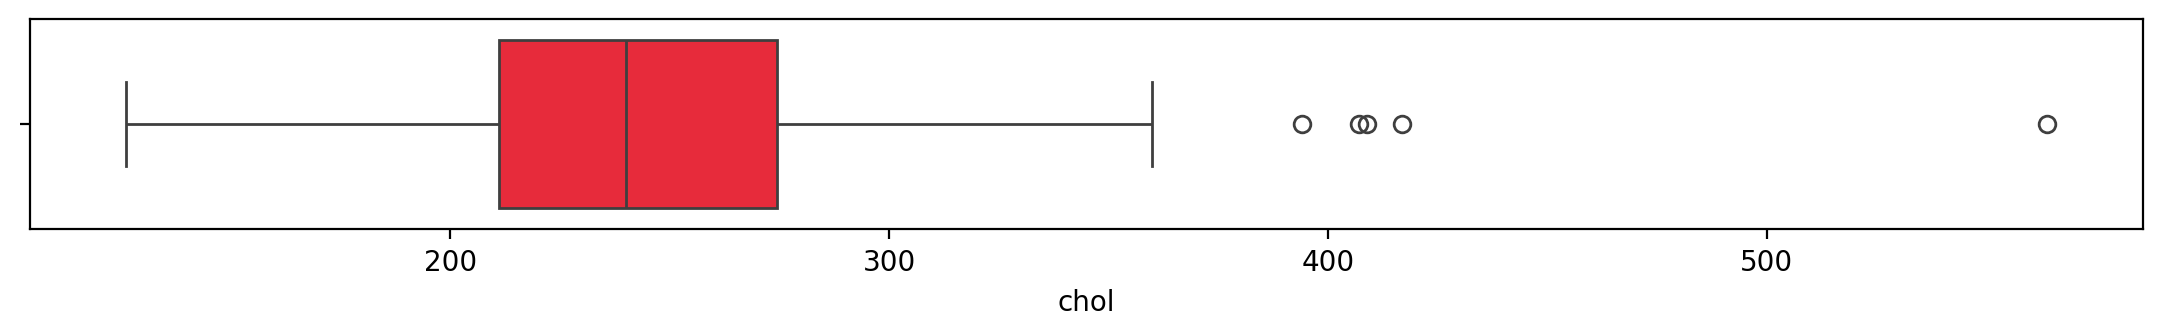

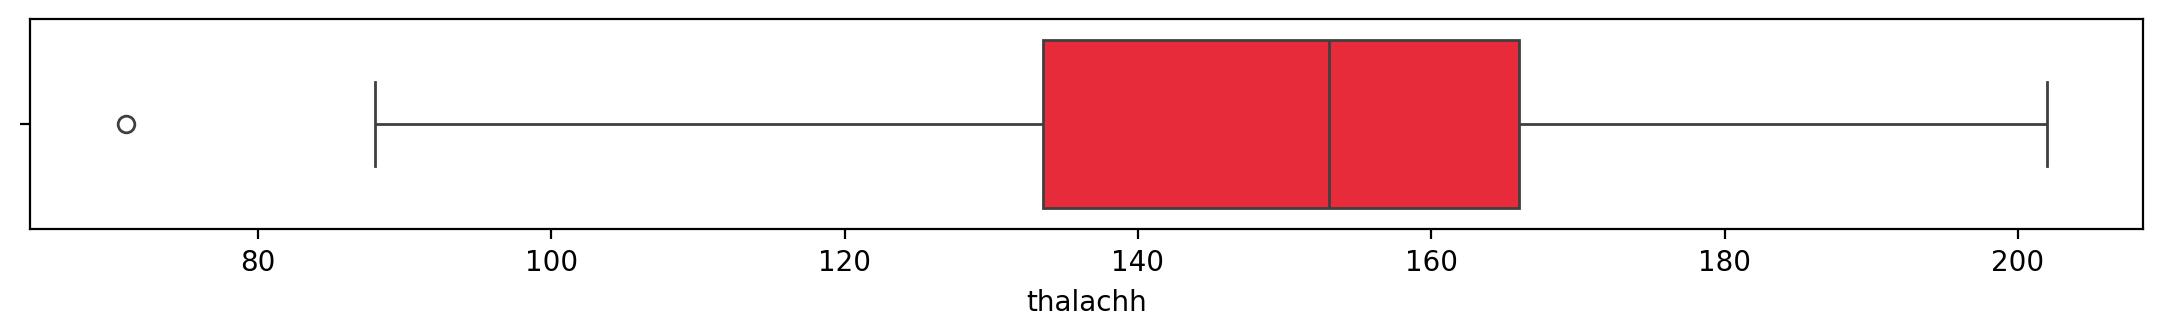

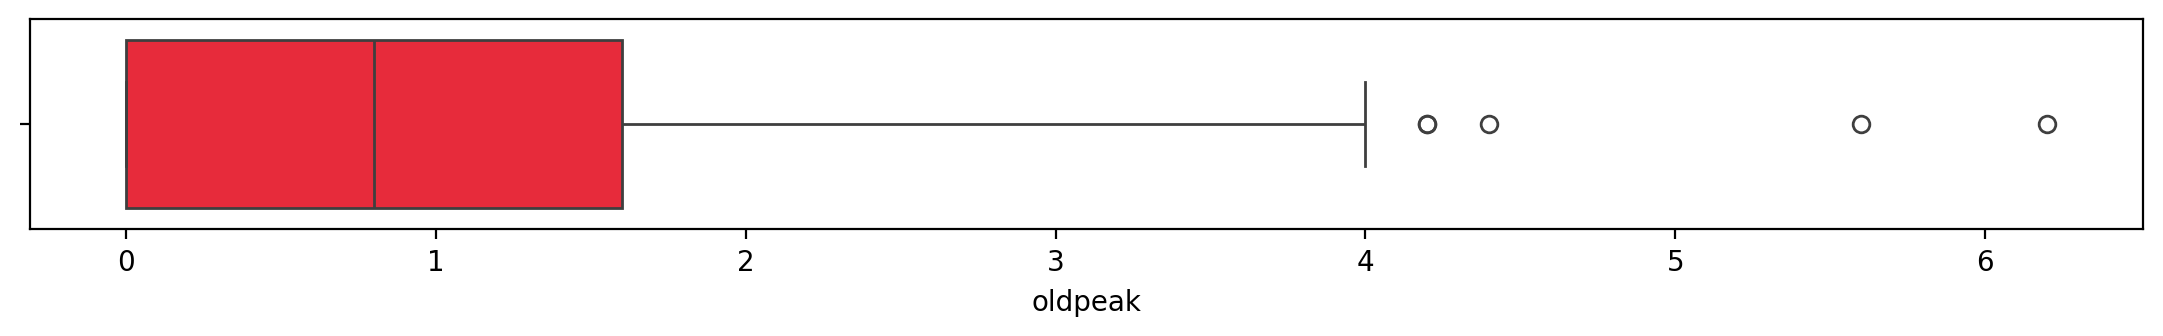

In [ ]:
Numerical = ['age', 'trtbps','chol','thalachh','oldpeak']
i = 0
while i < 5:
    fig = plt.figure(figsize = [30,3], dpi=200)
    plt.subplot(2,2,1)
    sns.boxplot(x = Numerical[i], data = Main_Dataset,
           boxprops = dict(facecolor = "#E72B3B"))
    i += 1
    plt.show()

In [ ]:
Chol_noise = Main_Dataset[Main_Dataset["chol"]>500].index
Chol_noise

Int64Index([85], dtype='int64')

In [ ]:
Main_Dataset.drop(index=[85], inplace=True)
Main_Dataset.shape

(302, 14)

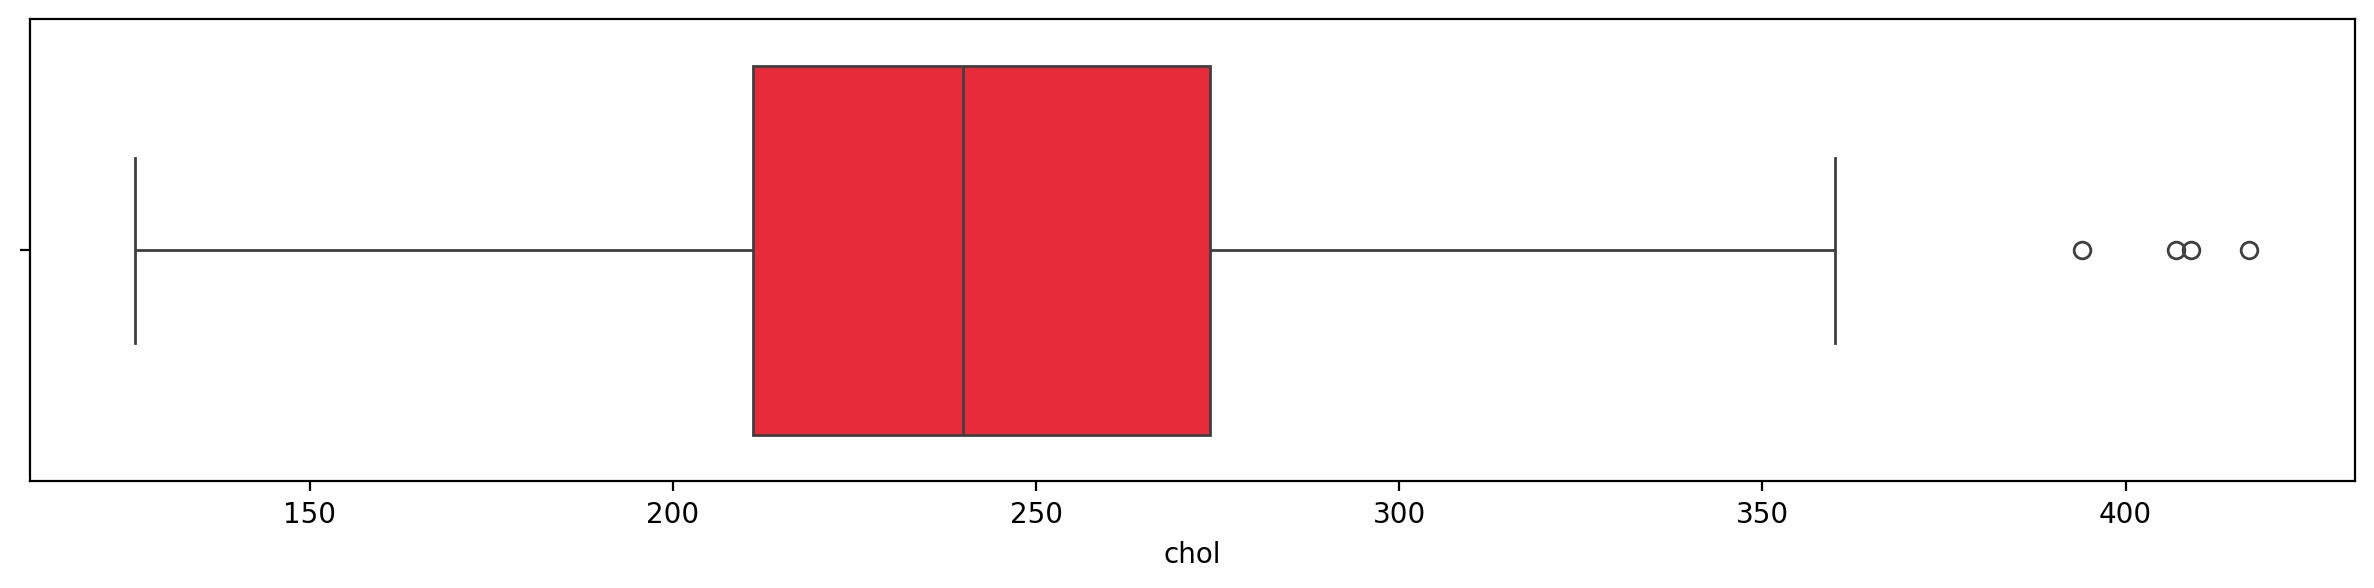

In [ ]:
fig = plt.figure(figsize = [15,3], dpi=200)
sns.boxplot(x = 'chol', data = Main_Dataset,
        boxprops = dict(facecolor = "#E72B3B"))

plt.show()

In [ ]:
Target_0_data = Main_Dataset[Main_Dataset["output"]==0]
Target_0_data = pd.DataFrame(Target_0_data)
Target_1_data = Main_Dataset[Main_Dataset["output"]==1]
Target_1_data = pd.DataFrame(Target_1_data)
print("The shape of data when target is '0': Not disease",Target_0_data.shape)
print("The shape of data when target is '1': Disease",Target_1_data.shape)

The shape of data when target is '0': Not disease (138, 14)
The shape of data when target is '1': Disease (164, 14)


In [ ]:
Target_0_data.sort_values(by=['age'], inplace=True)
Target_1_data.sort_values(by=['age'], inplace=True)

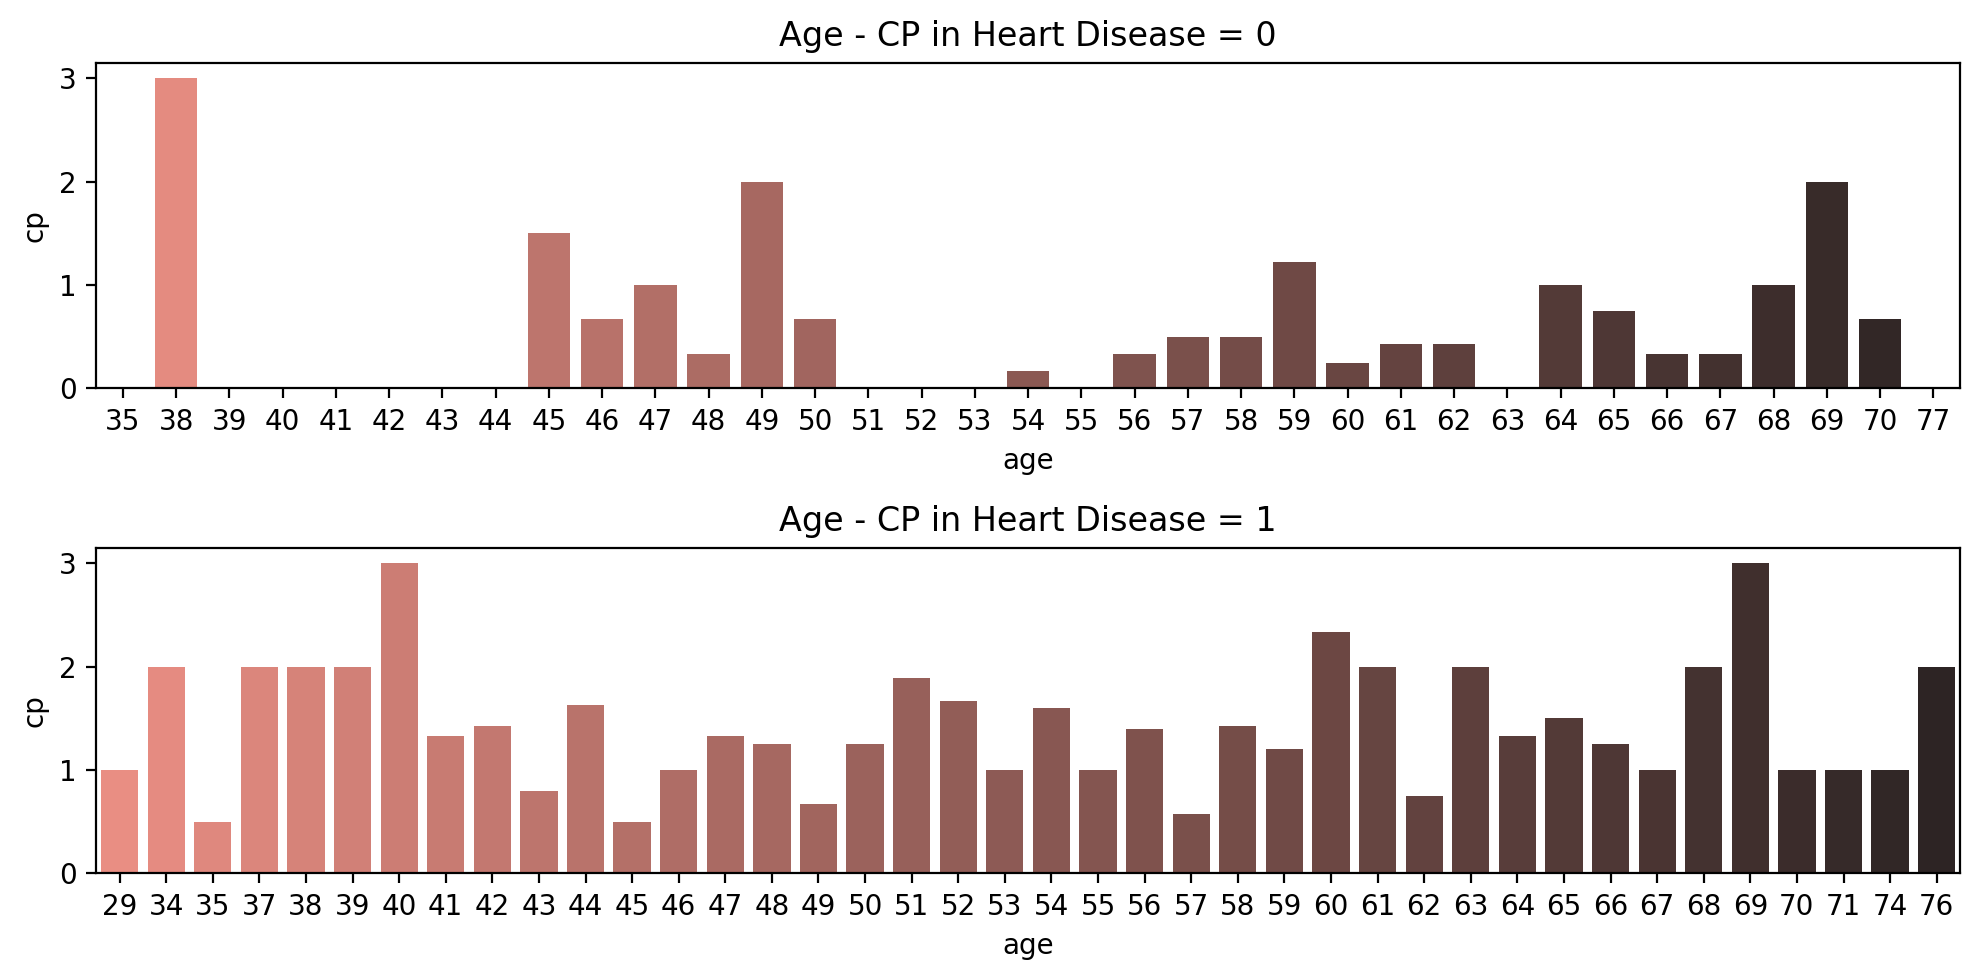

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), dpi=200)
sns.barplot(x= Target_0_data['age'], y= Target_0_data['cp'], errorbar=None,
            palette="dark:salmon_r",ax= axes[0]).set(title='Age - CP in Heart Disease = 0')
sns.barplot(x= Target_1_data['age'], y= Target_1_data['cp'], errorbar=None,
            palette="dark:salmon_r",ax= axes[1]).set(title='Age - CP in Heart Disease = 1')


plt.tight_layout()

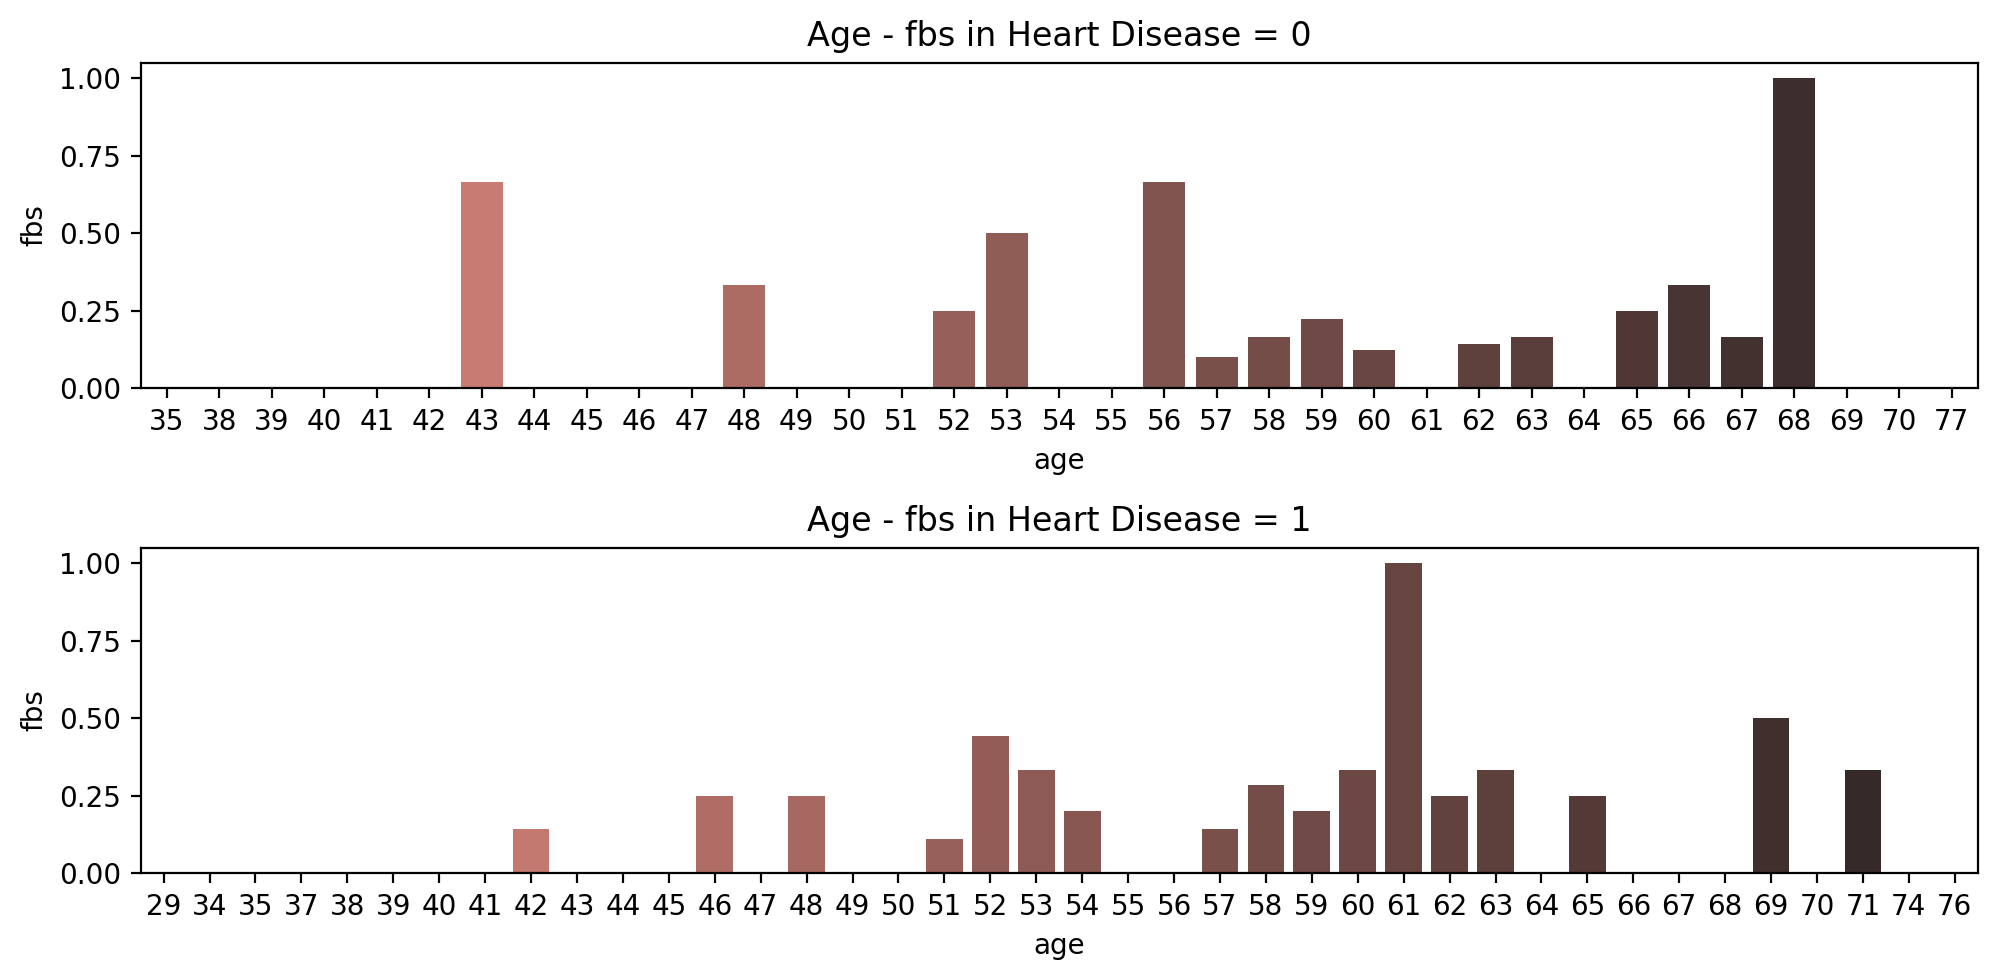

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), dpi=200)
sns.barplot(x= Target_0_data['age'], y= Target_0_data['fbs'], errorbar=None,
            palette="dark:salmon_r",ax= axes[0]).set(title='Age - fbs in Heart Disease = 0')
sns.barplot(x= Target_1_data['age'], y= Target_1_data['fbs'], errorbar=None,
            palette="dark:salmon_r",ax= axes[1]).set(title='Age - fbs in Heart Disease = 1')


plt.tight_layout()

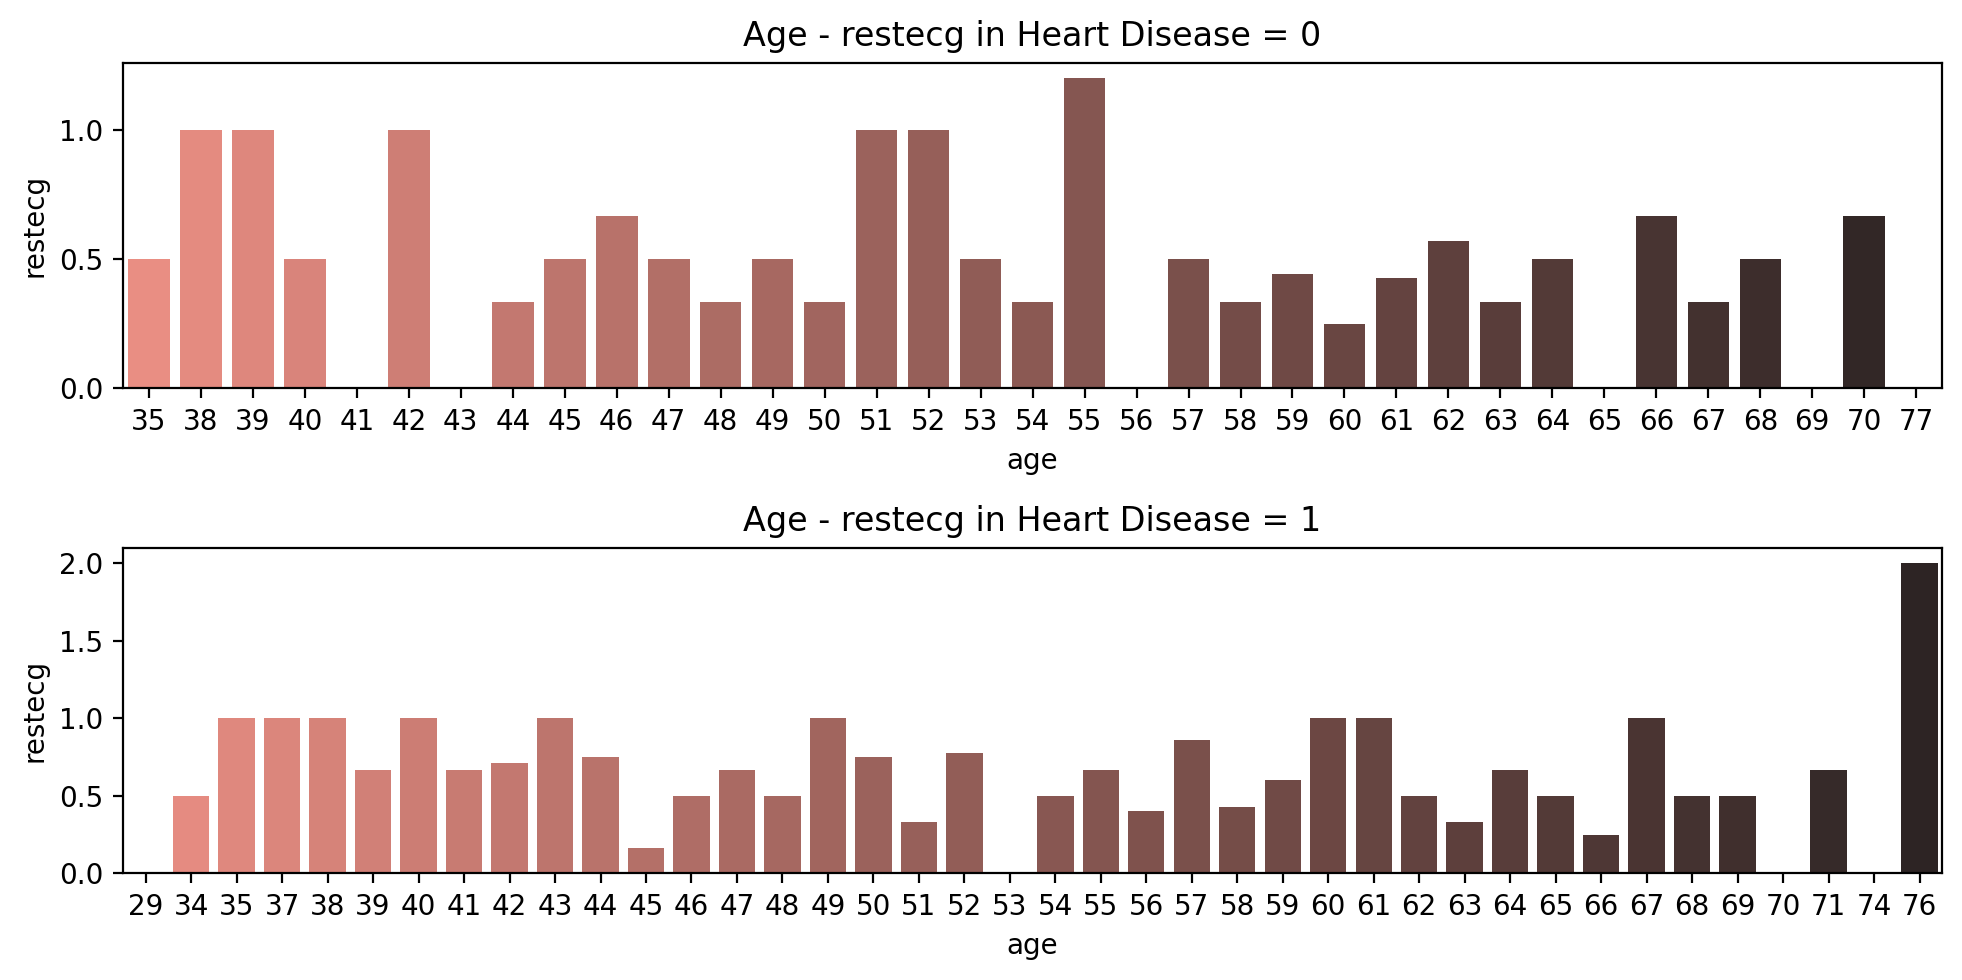

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), dpi=200)
sns.barplot(x= Target_0_data['age'], y= Target_0_data['restecg'], errorbar=None,
            palette="dark:salmon_r",ax= axes[0]).set(title='Age - restecg in Heart Disease = 0')
sns.barplot(x= Target_1_data['age'], y= Target_1_data['restecg'], errorbar=None,
            palette="dark:salmon_r",ax= axes[1]).set(title='Age - restecg in Heart Disease = 1')


plt.tight_layout()

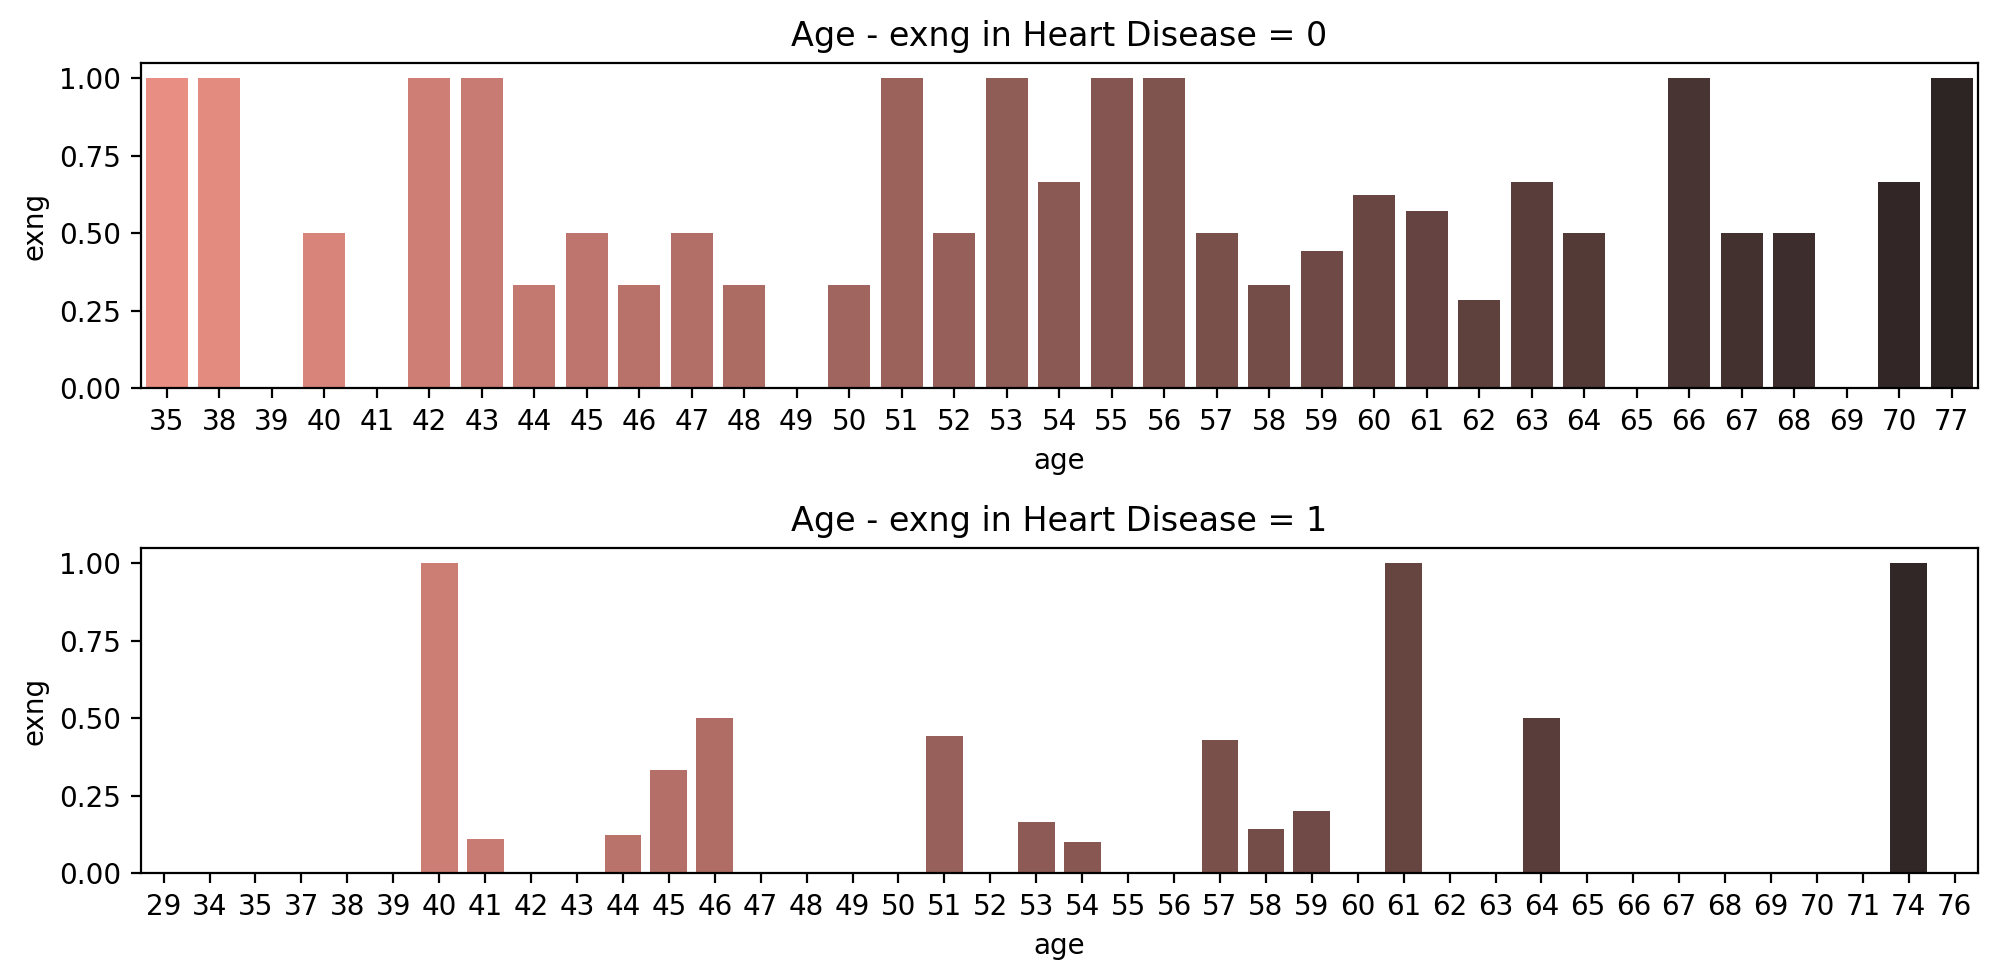

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), dpi=200)
sns.barplot(x= Target_0_data['age'], y= Target_0_data['exng'], errorbar=None,
            palette="dark:salmon_r",ax= axes[0]).set(title='Age - exng in Heart Disease = 0')
sns.barplot(x= Target_1_data['age'], y= Target_1_data['exng'], errorbar=None,
            palette="dark:salmon_r",ax= axes[1]).set(title='Age - exng in Heart Disease = 1')


plt.tight_layout()

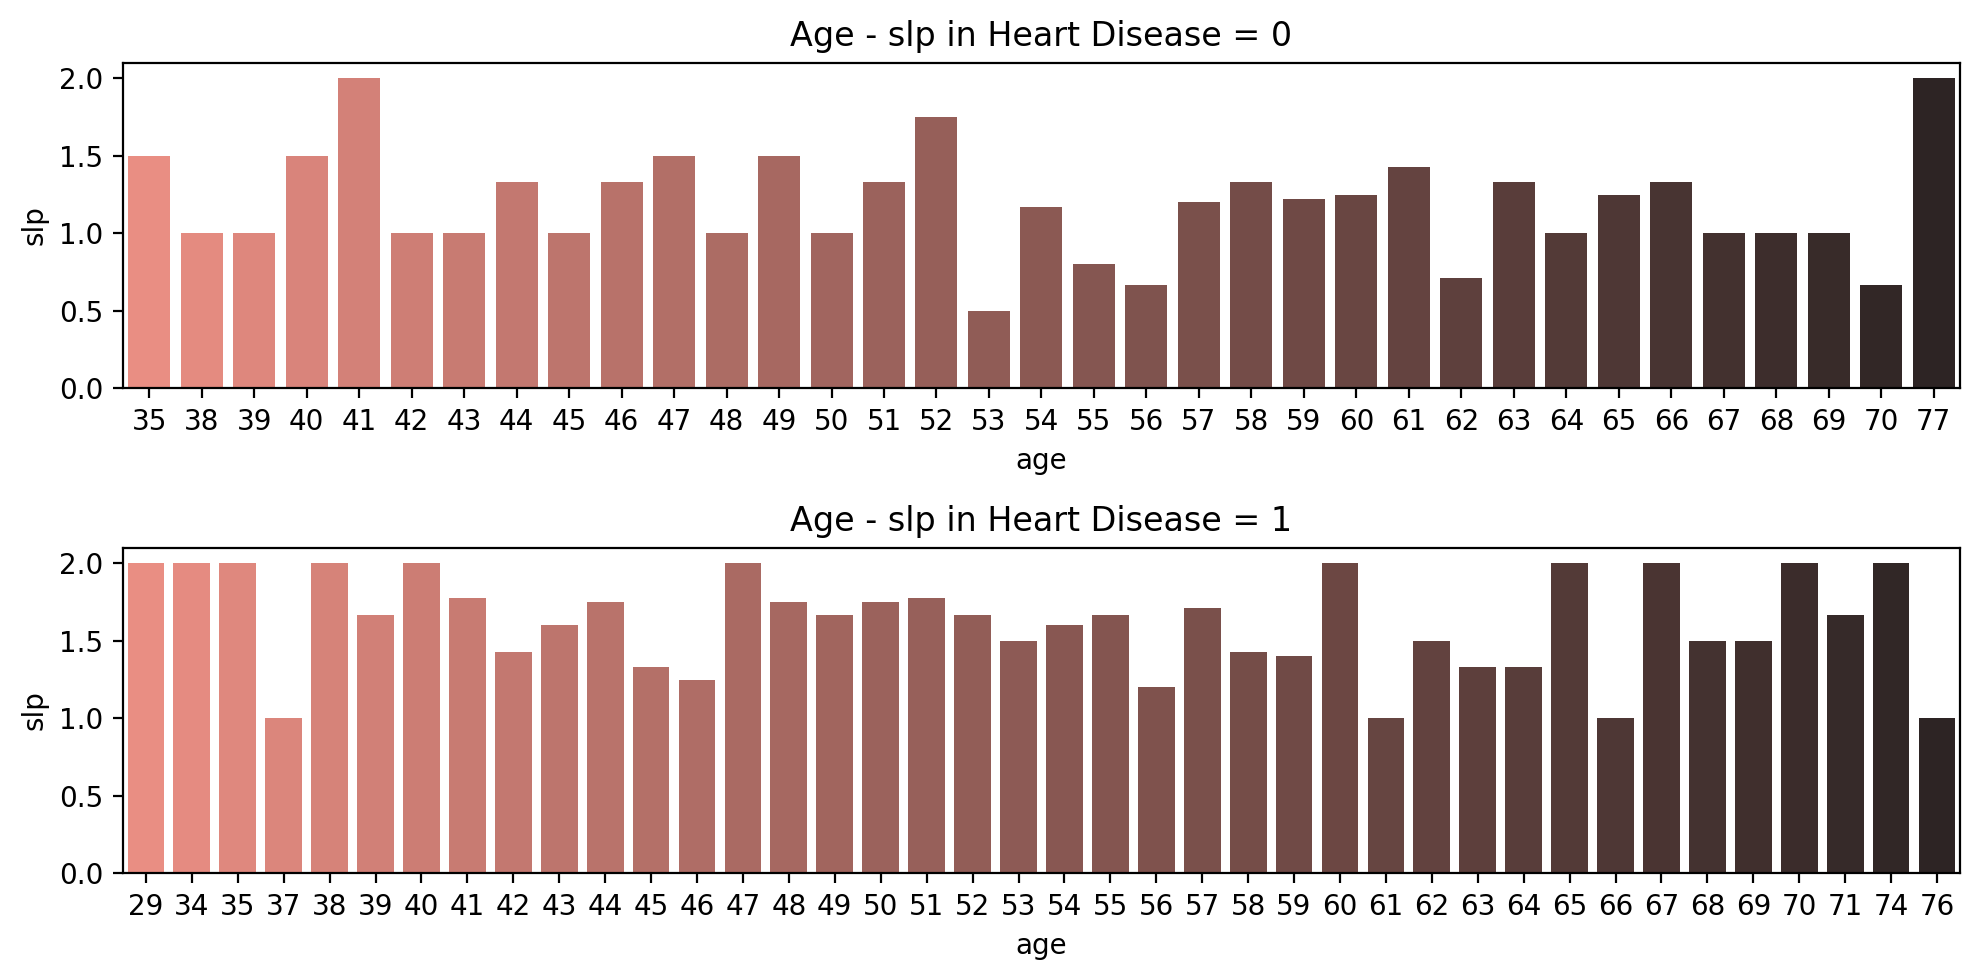

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), dpi=200)
sns.barplot(x= Target_0_data['age'], y= Target_0_data['slp'], errorbar=None,
            palette="dark:salmon_r",ax= axes[0]).set(title='Age - slp in Heart Disease = 0')
sns.barplot(x= Target_1_data['age'], y= Target_1_data['slp'], errorbar=None,
            palette="dark:salmon_r",ax= axes[1]).set(title='Age - slp in Heart Disease = 1')


plt.tight_layout()

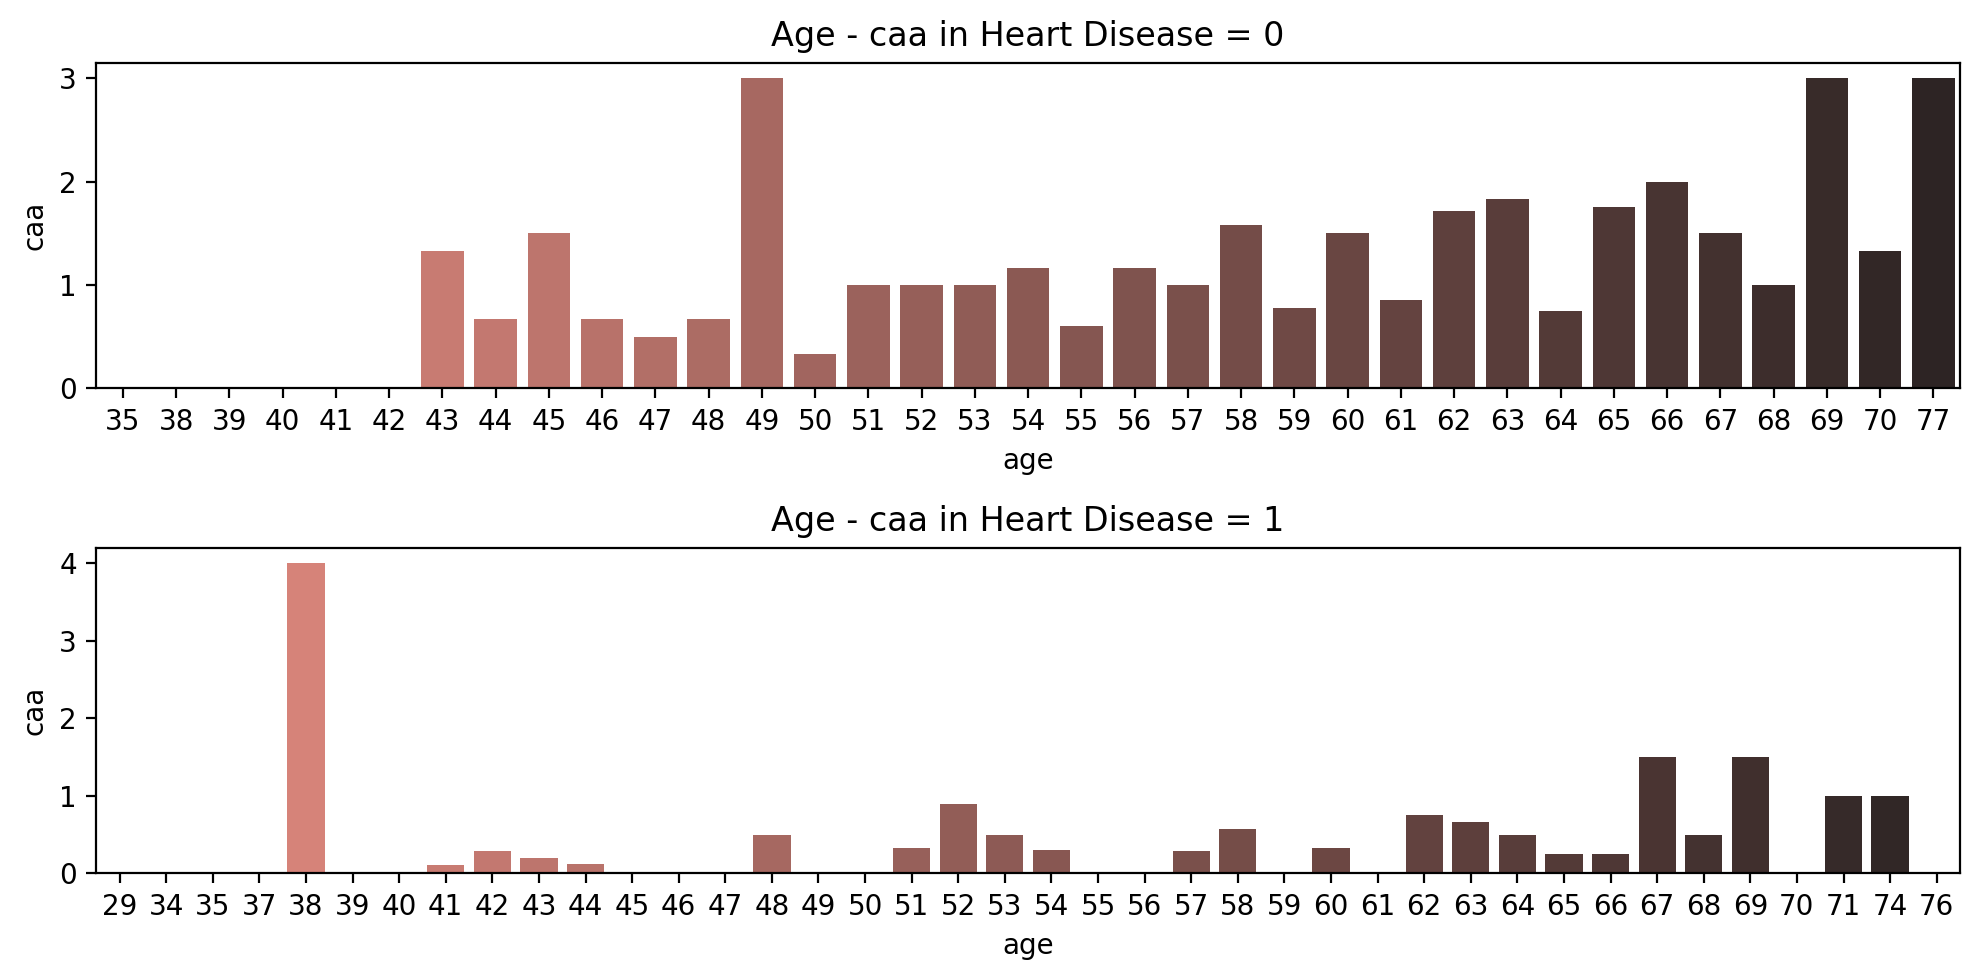

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), dpi=200)
sns.barplot(x= Target_0_data['age'], y= Target_0_data['caa'], errorbar=None,
            palette="dark:salmon_r",ax= axes[0]).set(title='Age - caa in Heart Disease = 0')
sns.barplot(x= Target_1_data['age'], y= Target_1_data['caa'], errorbar=None,
            palette="dark:salmon_r",ax= axes[1]).set(title='Age - caa in Heart Disease = 1')


plt.tight_layout()

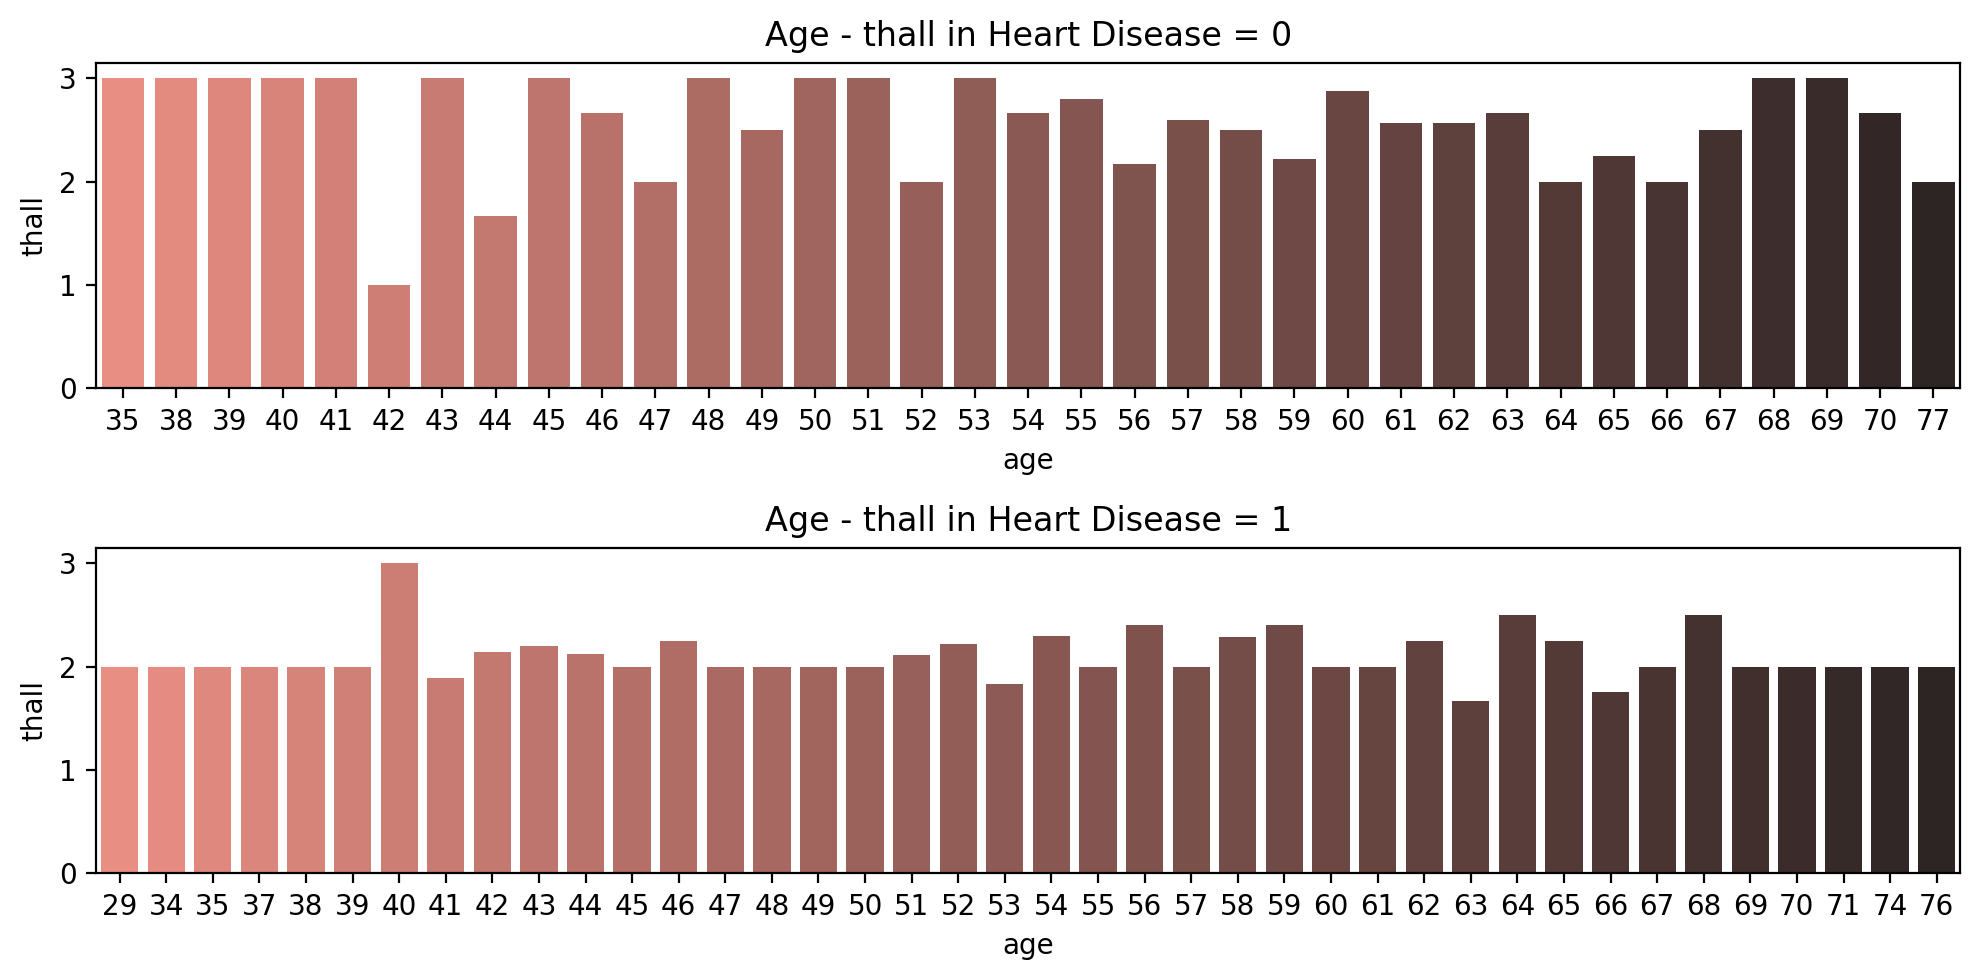

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5), dpi=200)
sns.barplot(x= Target_0_data['age'], y= Target_0_data['thall'], errorbar=None,
            palette="dark:salmon_r",ax= axes[0]).set(title='Age - thall in Heart Disease = 0')
sns.barplot(x= Target_1_data['age'], y= Target_1_data['thall'], errorbar=None,
            palette="dark:salmon_r",ax= axes[1]).set(title='Age - thall in Heart Disease = 1')


plt.tight_layout()

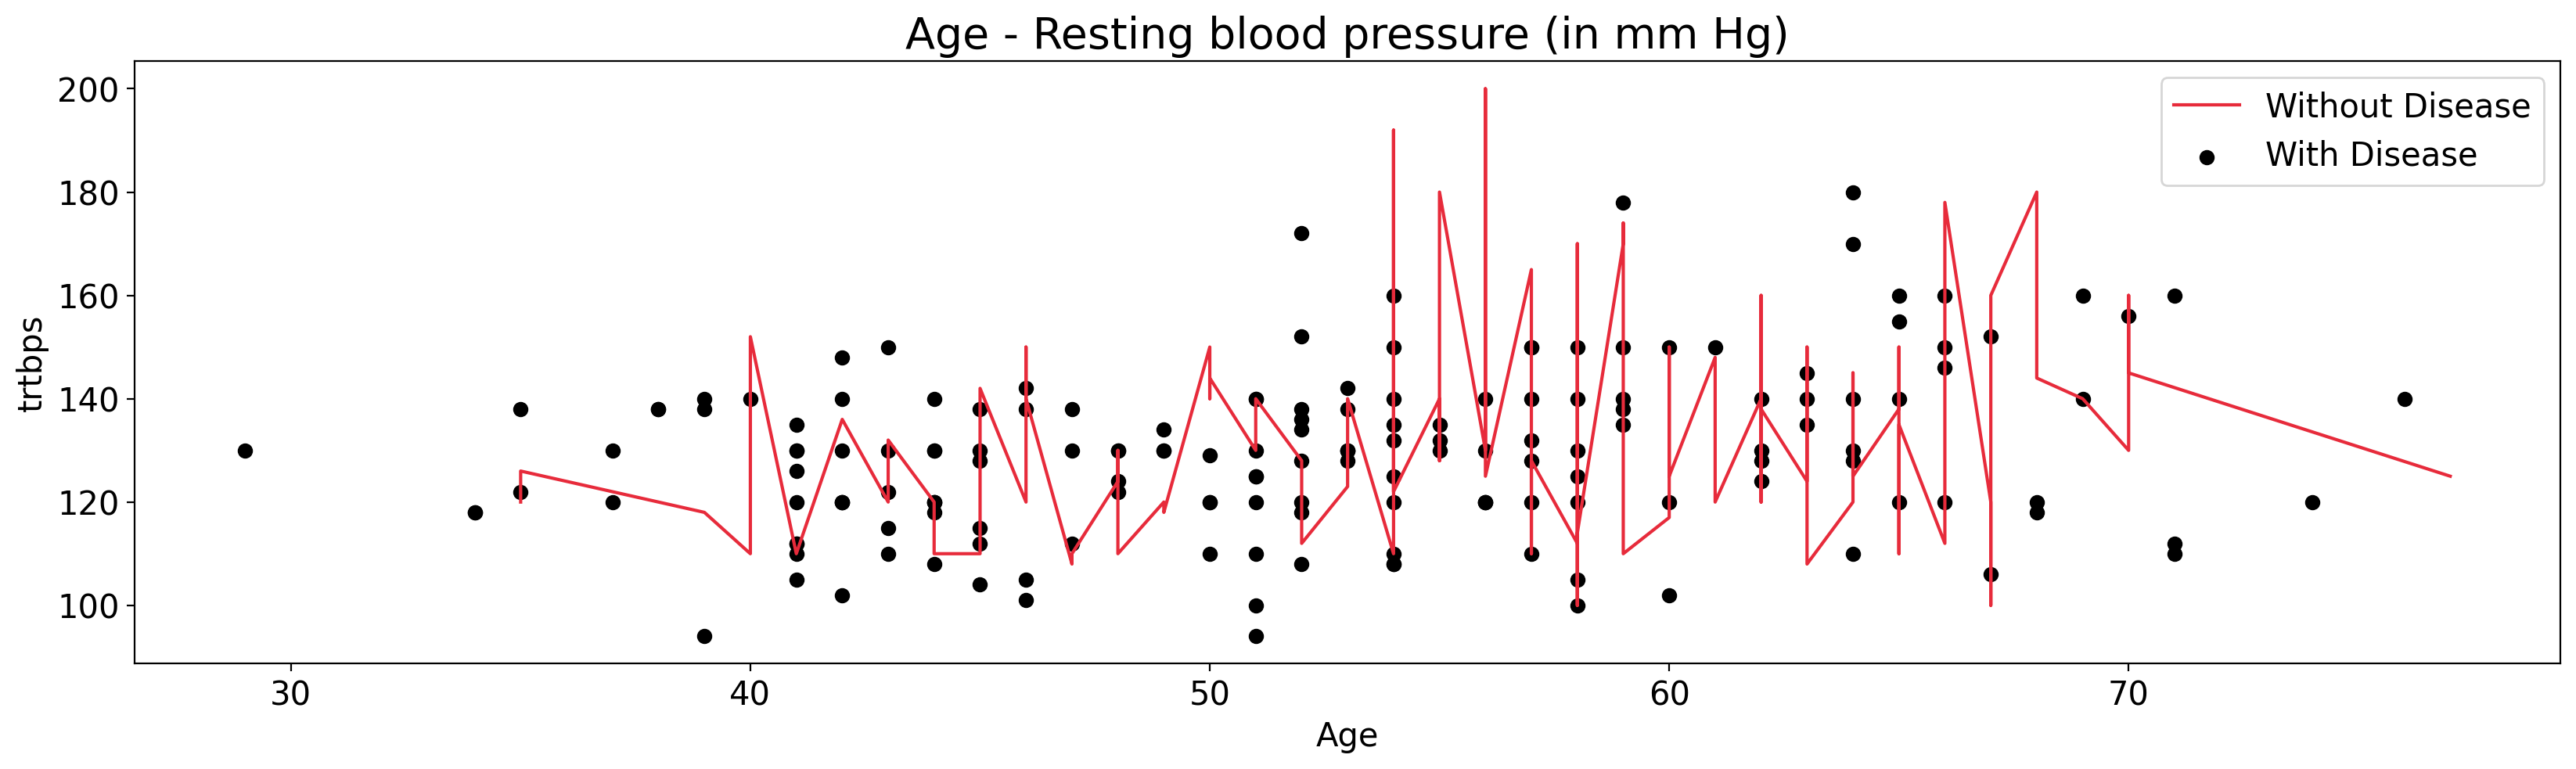

In [ ]:
plt.figure(figsize=(20,5), dpi=200)
plt.plot(Target_0_data['age'], Target_0_data['trtbps'], color= '#E72B3B')
plt.scatter(Target_1_data['age'], Target_1_data['trtbps'], color= 'black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(["Without Disease","With Disease"], fontsize=15)

plt.title("Age - Resting blood pressure (in mm Hg)", fontsize=20)
plt.xlabel("Age", fontsize=15)
plt.ylabel("trtbps", fontsize=15)


plt.show()

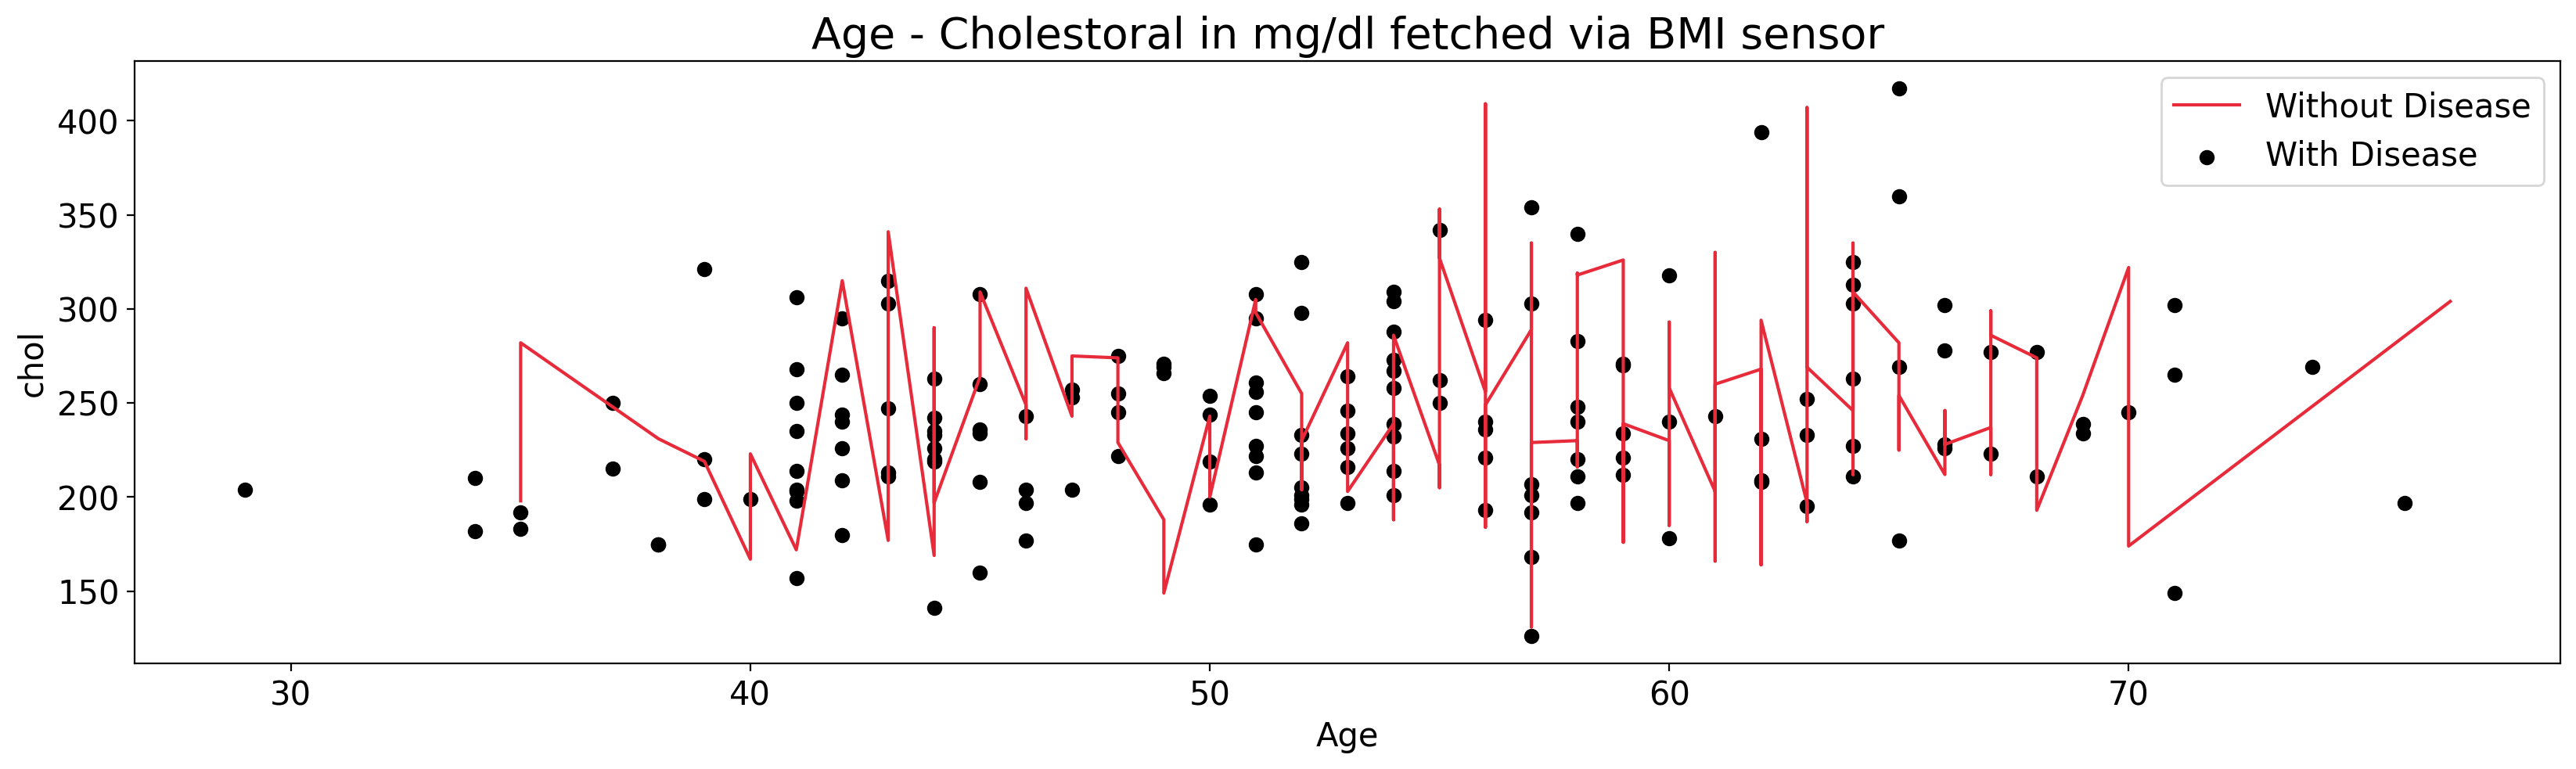

In [ ]:
plt.figure(figsize=(20,5), dpi=200)
plt.plot(Target_0_data['age'], Target_0_data['chol'], color= '#E72B3B')
plt.scatter(Target_1_data['age'], Target_1_data['chol'], color= 'black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(["Without Disease","With Disease"], fontsize=15)

plt.title("Age - Cholestoral in mg/dl fetched via BMI sensor", fontsize=20)
plt.xlabel("Age", fontsize=15)
plt.ylabel("chol", fontsize=15)


plt.show()

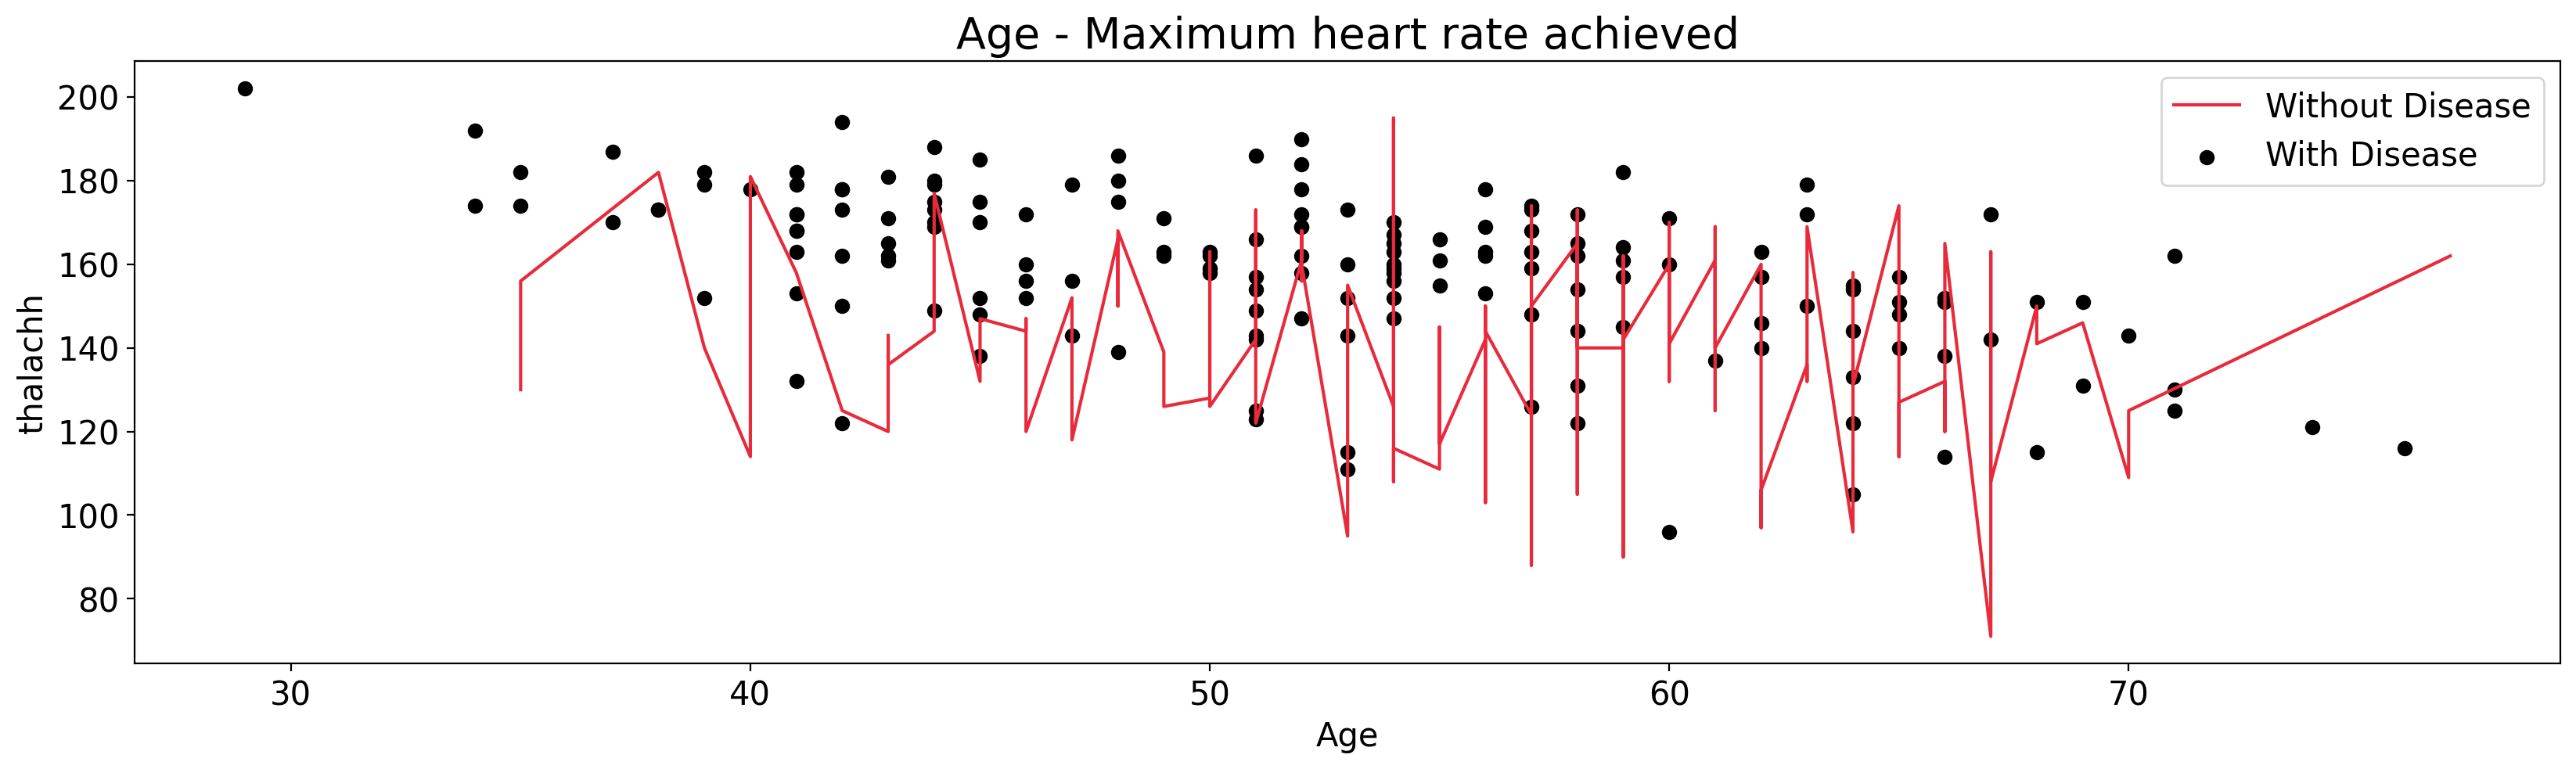

In [ ]:
plt.figure(figsize=(20,5), dpi=200)
plt.plot(Target_0_data['age'], Target_0_data['thalachh'], color= '#E72B3B')
plt.scatter(Target_1_data['age'], Target_1_data['thalachh'], color= 'black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(["Without Disease","With Disease"], fontsize=15)

plt.title("Age - Maximum heart rate achieved", fontsize=20)
plt.xlabel("Age", fontsize=15)
plt.ylabel("thalachh", fontsize=15)


plt.show()

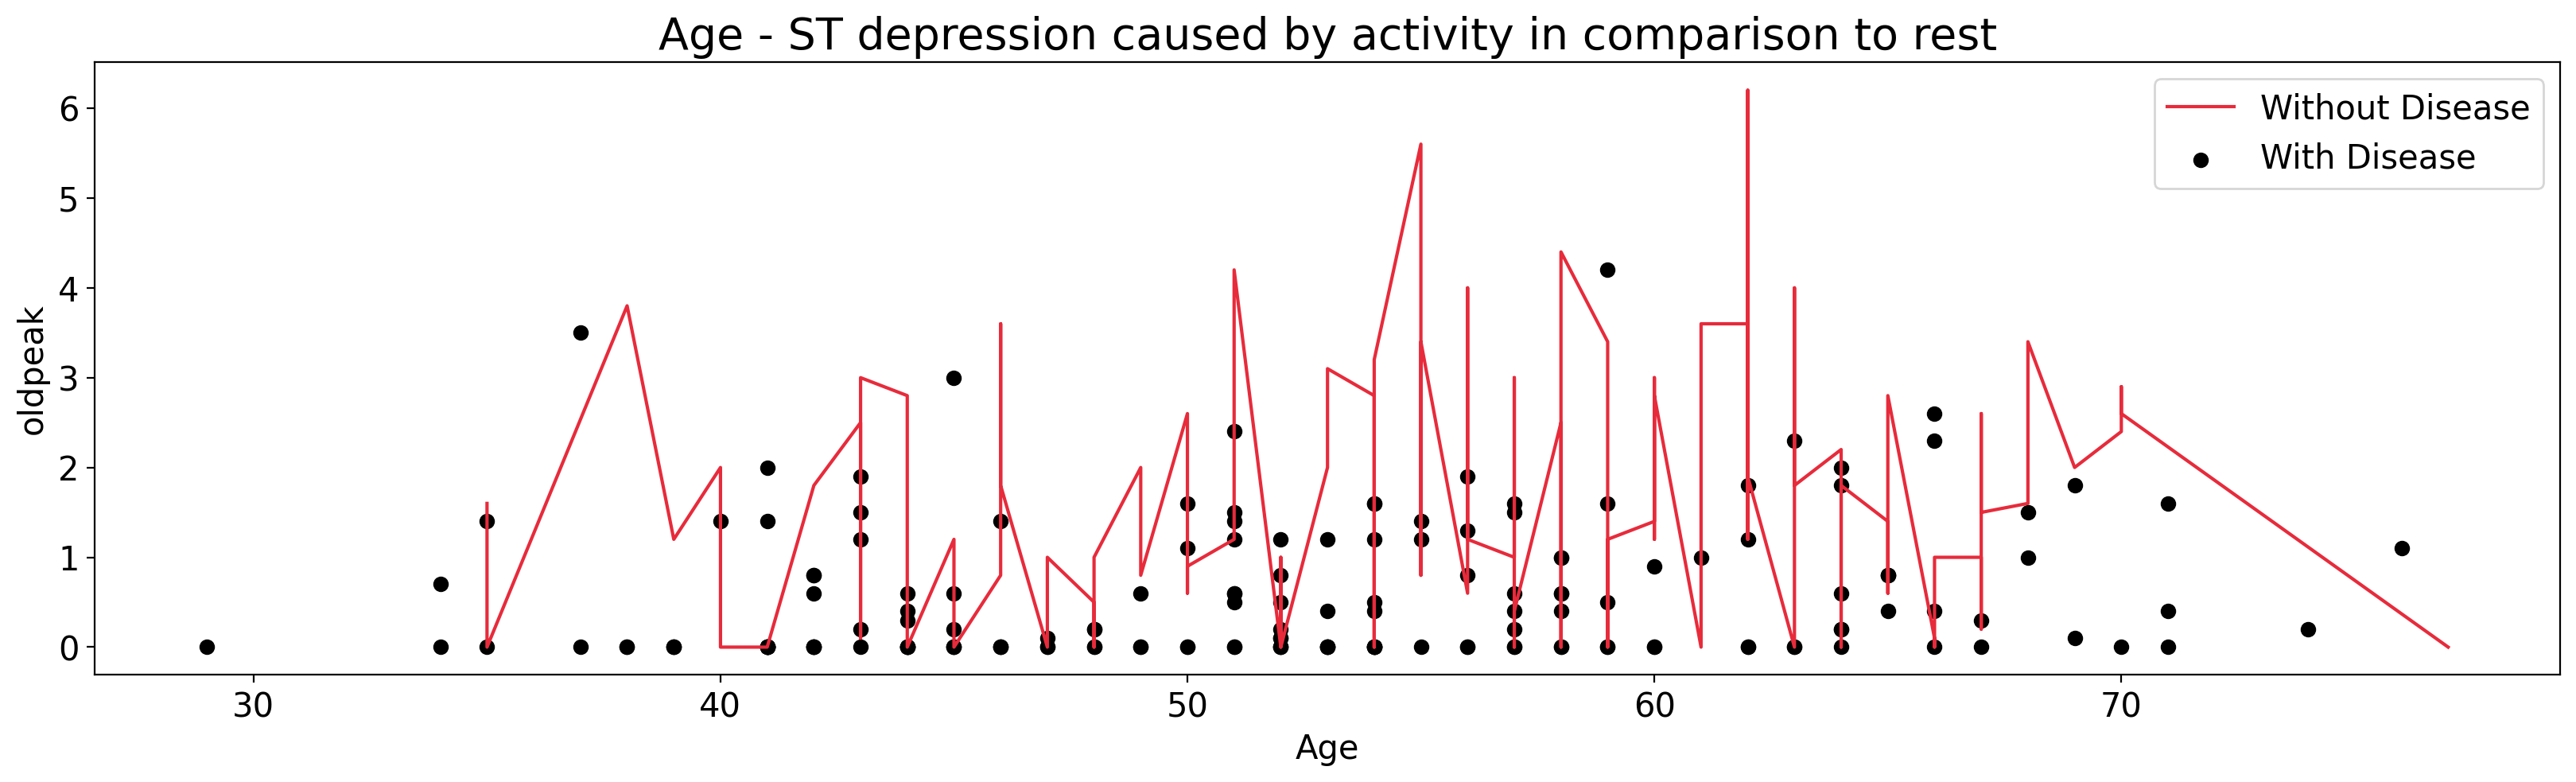

In [ ]:
plt.figure(figsize=(20,5), dpi=200)
plt.plot(Target_0_data['age'], Target_0_data['oldpeak'], color= '#E72B3B')
plt.scatter(Target_1_data['age'], Target_1_data['oldpeak'], color= 'black')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(["Without Disease","With Disease"], fontsize=15)

plt.title("Age - ST depression caused by activity in comparison to rest", fontsize=20)
plt.xlabel("Age", fontsize=15)
plt.ylabel("oldpeak", fontsize=15)


plt.show()

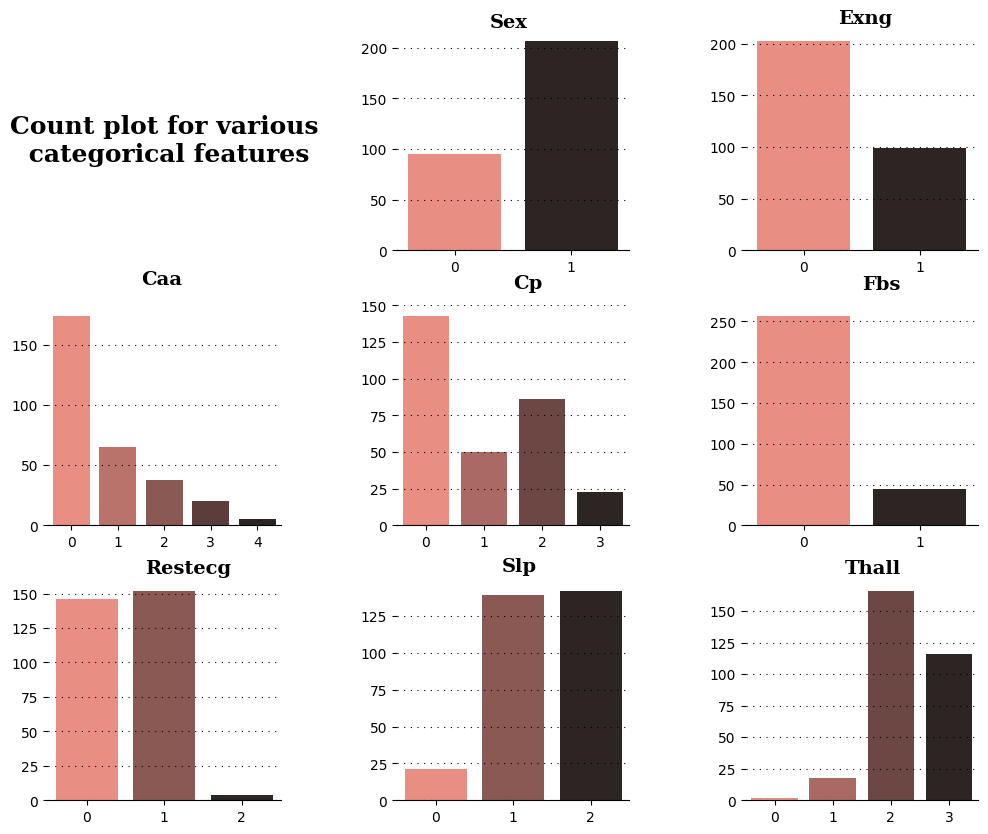

In [ ]:
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "white"
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for various\n categorical features',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Sex count
ax1.text(0.3, 220, 'Sex', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1,data=Main_Dataset,x='sex',palette="dark:salmon_r")
ax1.set_xlabel("")
ax1.set_ylabel("")

# Exng count
ax2.text(0.3, 220, 'Exng', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2,data=Main_Dataset,x='exng',palette="dark:salmon_r")
ax2.set_xlabel("")
ax2.set_ylabel("")

# Caa count
ax3.text(1.5, 200, 'Caa', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3,data=Main_Dataset,x='caa',palette="dark:salmon_r")
ax3.set_xlabel("")
ax3.set_ylabel("")

# Cp count
ax4.text(1.5, 162, 'Cp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4,data=Main_Dataset,x='cp',palette="dark:salmon_r")
ax4.set_xlabel("")
ax4.set_ylabel("")

# Fbs count
ax5.text(0.5, 290, 'Fbs', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5,data=Main_Dataset,x='fbs',palette="dark:salmon_r")
ax5.set_xlabel("")
ax5.set_ylabel("")

# Restecg count
ax6.text(0.75, 165, 'Restecg', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax6,data=Main_Dataset,x='restecg',palette="dark:salmon_r")
ax6.set_xlabel("")
ax6.set_ylabel("")

# Slp count
ax7.text(0.85, 155, 'Slp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax7,data=Main_Dataset,x='slp',palette="dark:salmon_r")
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thall count
ax8.text(1.2, 180, 'Thall', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax8,data=Main_Dataset,x='thall',palette="dark:salmon_r")
ax8.set_xlabel("")
ax8.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

In [ ]:
Features = Main_Dataset.drop(columns='output')
Features = pd.DataFrame(Features)

In [ ]:
scaler = MinMaxScaler()
Norm_data = scaler.fit_transform(Features)
Norm_df = pd.DataFrame(Norm_data, columns= Features.columns)

desc_norm_df = describe(Norm_df)
desc_norm_df = desc_norm_df.style.set_caption('Overview of the dataset').set_table_styles(Styles)
desc_norm_df.set_properties(**{'background-color': '#F6E7E8',
                           'color': 'black',
                           'border-color': 'black'})

,variable,dtype,count,unique,missing value,Min,Max
0,age,float64,302,41,0,0.000000,1.000000
1,sex,float64,302,2,0,0.000000,1.000000
2,cp,float64,302,4,0,0.000000,1.000000
3,trtbps,float64,302,49,0,0.000000,1.000000
4,chol,float64,302,151,0,0.000000,1.000000
5,fbs,float64,302,2,0,0.000000,1.000000
6,restecg,float64,302,3,0,0.000000,1.000000
7,thalachh,float64,302,91,0,0.000000,1.000000
8,exng,float64,302,2,0,0.000000,1.000000
9,oldpeak,float64,302,40,0,0.000000,1.000000


In [ ]:
Norm_df.head(10).style.set_properties(**{'background-color': '#F6E7E8',
                           'color': 'black',
                           'border-color': 'black'})

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,0.708333,1.000000,1.000000,0.481132,0.367698,1.000000,0.000000,0.603053,0.000000,0.370968,0.000000,0.000000,0.333333
1,0.166667,1.000000,0.666667,0.339623,0.426117,0.000000,0.500000,0.885496,0.000000,0.564516,0.000000,0.000000,0.666667
2,0.250000,0.000000,0.333333,0.339623,0.268041,0.000000,0.000000,0.770992,0.000000,0.225806,1.000000,0.000000,0.666667
3,0.562500,1.000000,0.333333,0.245283,0.378007,0.000000,0.500000,0.816794,0.000000,0.129032,1.000000,0.000000,0.666667
4,0.583333,0.000000,0.000000,0.245283,0.783505,0.000000,0.500000,0.702290,1.000000,0.096774,1.000000,0.000000,0.666667
5,0.583333,1.000000,0.000000,0.433962,0.226804,0.000000,0.500000,0.587786,0.000000,0.064516,0.500000,0.000000,0.333333
6,0.562500,0.000000,0.333333,0.433962,0.577320,0.000000,0.000000,0.625954,0.000000,0.209677,0.500000,0.000000,0.666667
7,0.312500,1.000000,0.333333,0.245283,0.470790,0.000000,0.500000,0.778626,0.000000,0.000000,1.000000,0.000000,1.000000
8,0.479167,1.000000,0.666667,0.735849,0.250859,1.000000,0.500000,0.694656,0.000000,0.080645,1.000000,0.000000,1.000000
9,0.583333,1.000000,0.666667,0.528302,0.144330,0.000000,0.500000,0.786260,0.000000,0.258065,1.000000,0.000000,0.666667


In [ ]:
X = Norm_df#This dataframe is created for features
y = Main_Dataset['output'].values.reshape(-1,1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=40)

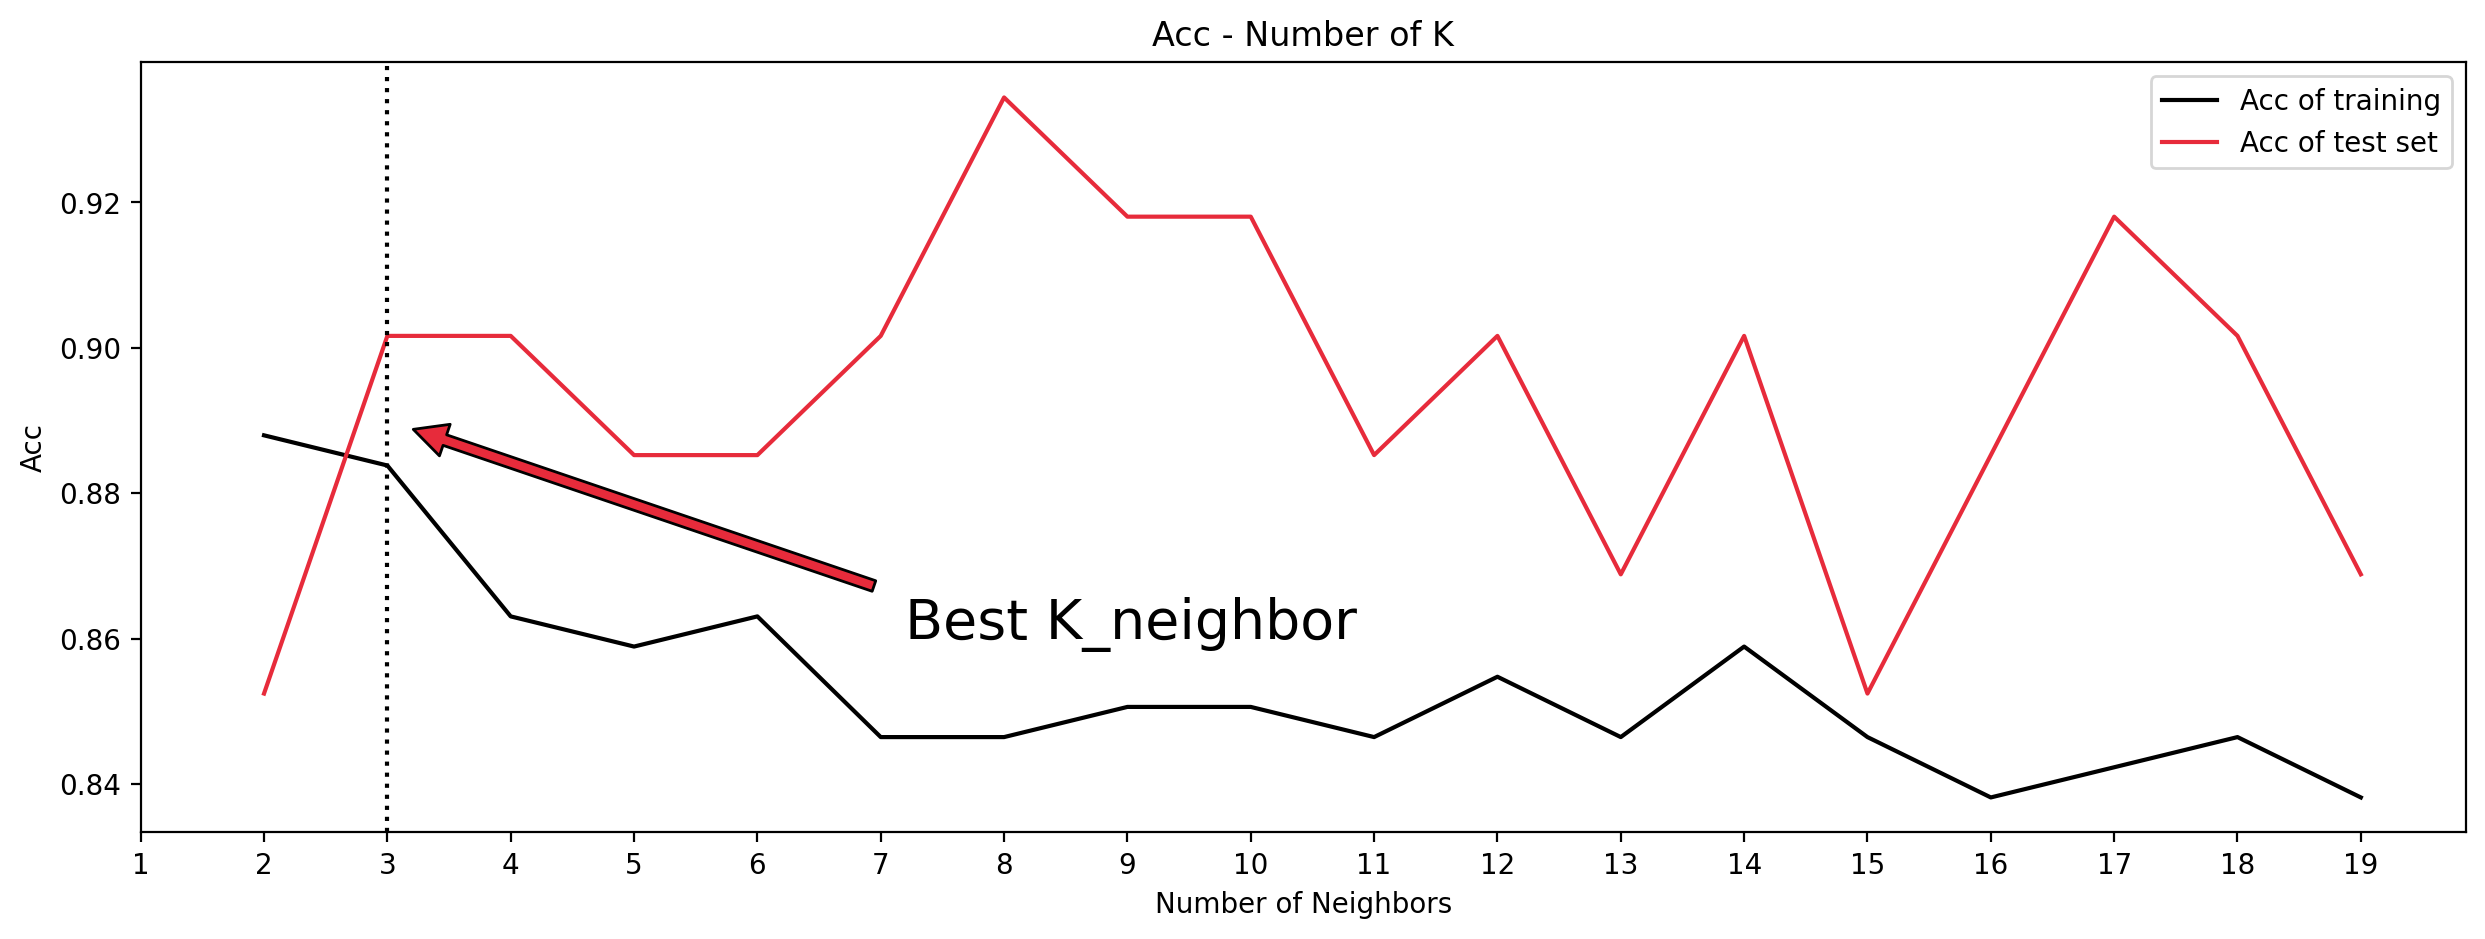

In [ ]:
training_acc_1 = []
test_acc_1 = []

range_k = range(2,20)

for number_k in range_k:
    knn = KNeighborsClassifier(n_neighbors = number_k, p=1)
    knn.fit (X_train, y_train.ravel())
    training_acc_1.append(knn.score(X_train,y_train))
    test_acc_1.append(knn.score(X_test, y_test))


plt.figure(figsize=(15,5), dpi=200)
plt.plot(range_k, training_acc_1, label='Acc of training', color= 'black')
plt.plot(range_k, test_acc_1, label='Acc of test set', color= '#E72B3B')
plt.ylabel('Acc')
plt.xlabel('Number of Neighbors')
plt.title('Acc - Number of K')
plt.legend()
plt.xticks(range(1,20))
plt.annotate('Best K_neighbor', xy=(3,0.89),xytext=(7.2,0.86), arrowprops=dict(facecolor='#E72B3B', shrink=0.05),fontsize=20)
plt.axvline(x = 3, linestyle= 'dotted', c= 'black')
plt.show()

In [ ]:
K = 3
clf_1 = KNeighborsClassifier(K, p=1)
clf_1.fit(X_train, y_train.ravel())
y_pred_1 = clf_1.predict(X_test)
print("Accuracy", metrics.accuracy_score(y_test,y_pred_1))
Best_knn = metrics.accuracy_score(y_test,y_pred_1)

Accuracy 0.9016393442622951


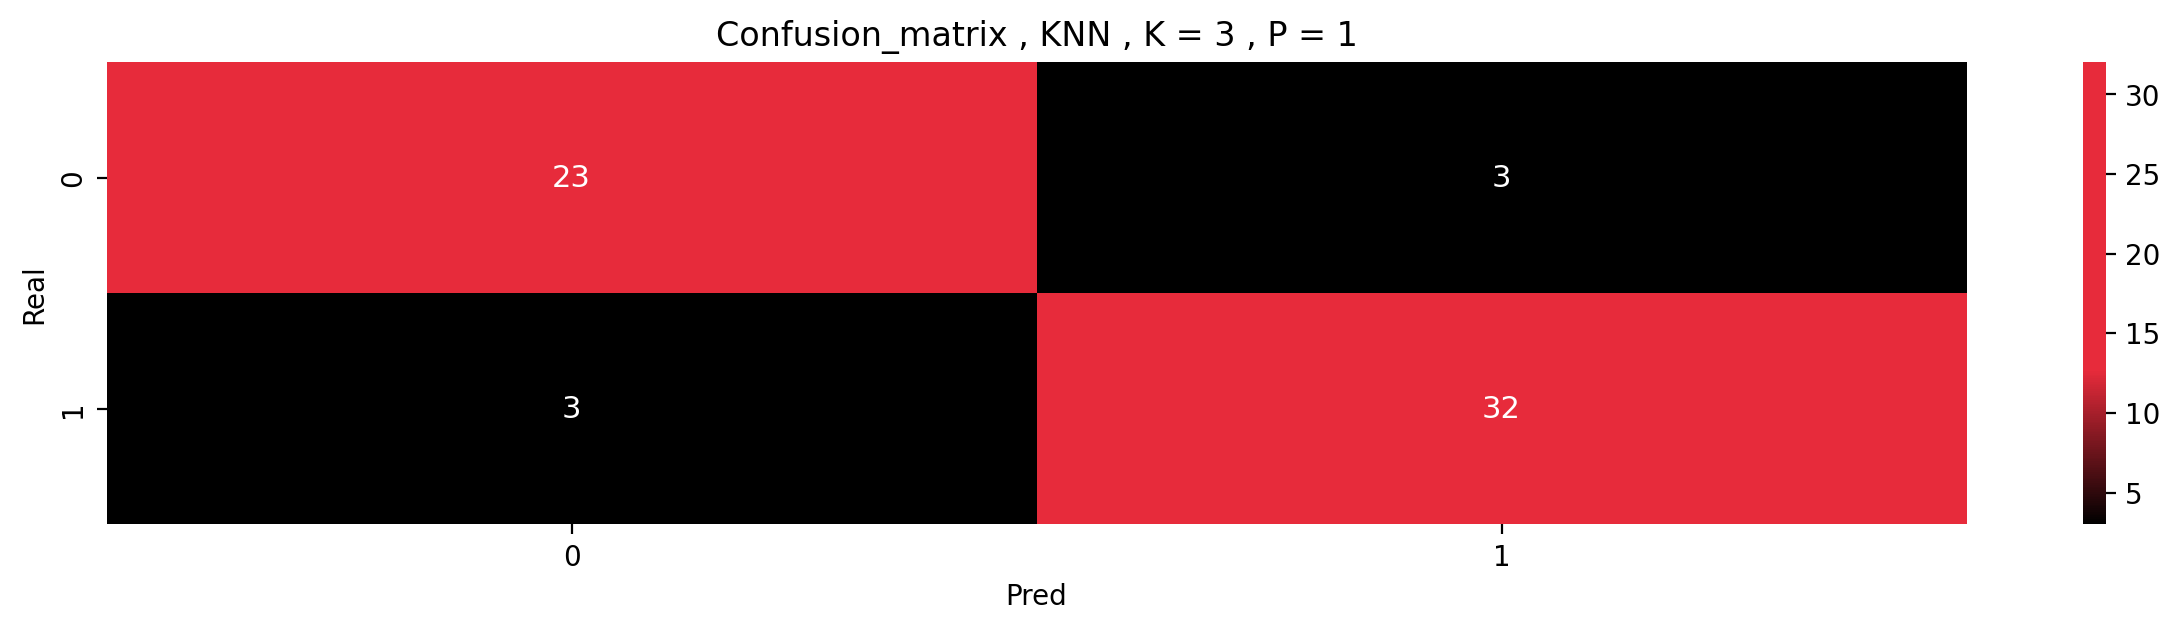

In [ ]:
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig = plt.figure(figsize=(15, 3), dpi=200)
ax = plt.subplot()
plt.title("Confusion_matrix , KNN , K = 3 , P = 1")
annot = np.array([[f"{conf_matrix_1[0, 0]}", f"{conf_matrix_1[0, 1]}"],
                  [f"{conf_matrix_1[1, 0]}", f"{conf_matrix_1[1, 1]}"]], dtype=object)


sns.heatmap(conf_matrix_1,
            annot=annot,
            annot_kws={"size": 11},
            ax=ax,
            fmt='',
            cmap=cmap,
            cbar=True,
            )
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

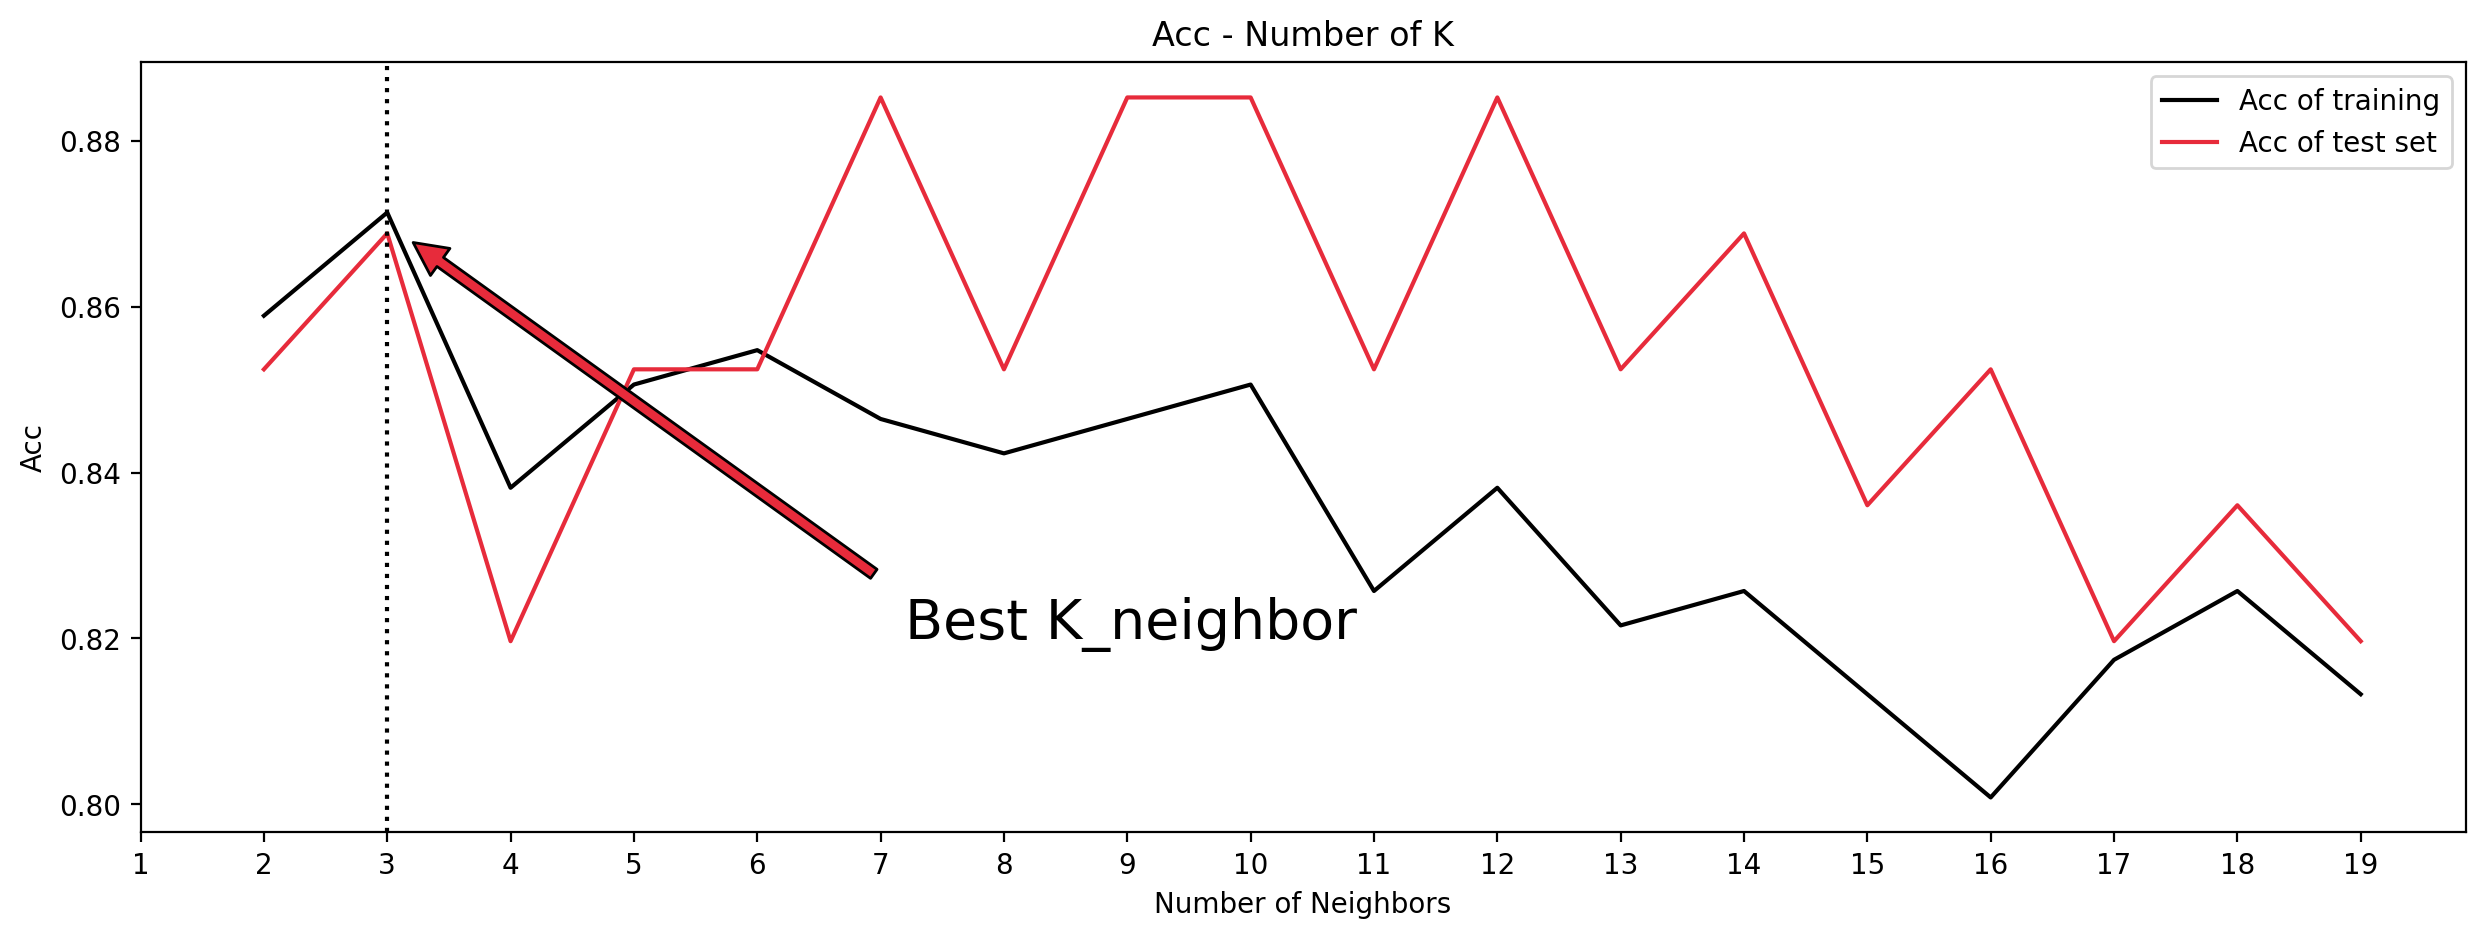

In [ ]:
training_acc_2 = []
test_acc_2 = []

range_k = range(2,20)

for number_k in range_k:
    knn = KNeighborsClassifier(n_neighbors = number_k, p=2)
    knn.fit (X_train, y_train.ravel())
    training_acc_2.append(knn.score(X_train,y_train))
    test_acc_2.append(knn.score(X_test, y_test))


plt.figure(figsize=(15,5), dpi=200)
plt.plot(range_k, training_acc_2, label='Acc of training', color= 'black')
plt.plot(range_k, test_acc_2, label='Acc of test set', color= '#E72B3B')
plt.ylabel('Acc')
plt.xlabel('Number of Neighbors')
plt.title('Acc - Number of K')
plt.legend()
plt.xticks(range(1,20))
plt.annotate('Best K_neighbor', xy=(3,0.87),xytext=(7.2,0.82), arrowprops=dict(facecolor='#E72B3B', shrink=0.05),fontsize=20)
plt.axvline(x = 3, linestyle= 'dotted', c= 'black')
plt.show()

In [ ]:
K = 3
clf_2 = KNeighborsClassifier(K, p=2)
clf_2.fit(X_train, y_train.ravel())
y_pred_2 = clf_2.predict(X_test)
print("Accuracy", metrics.accuracy_score(y_test,y_pred_2))

Accuracy 0.8688524590163934


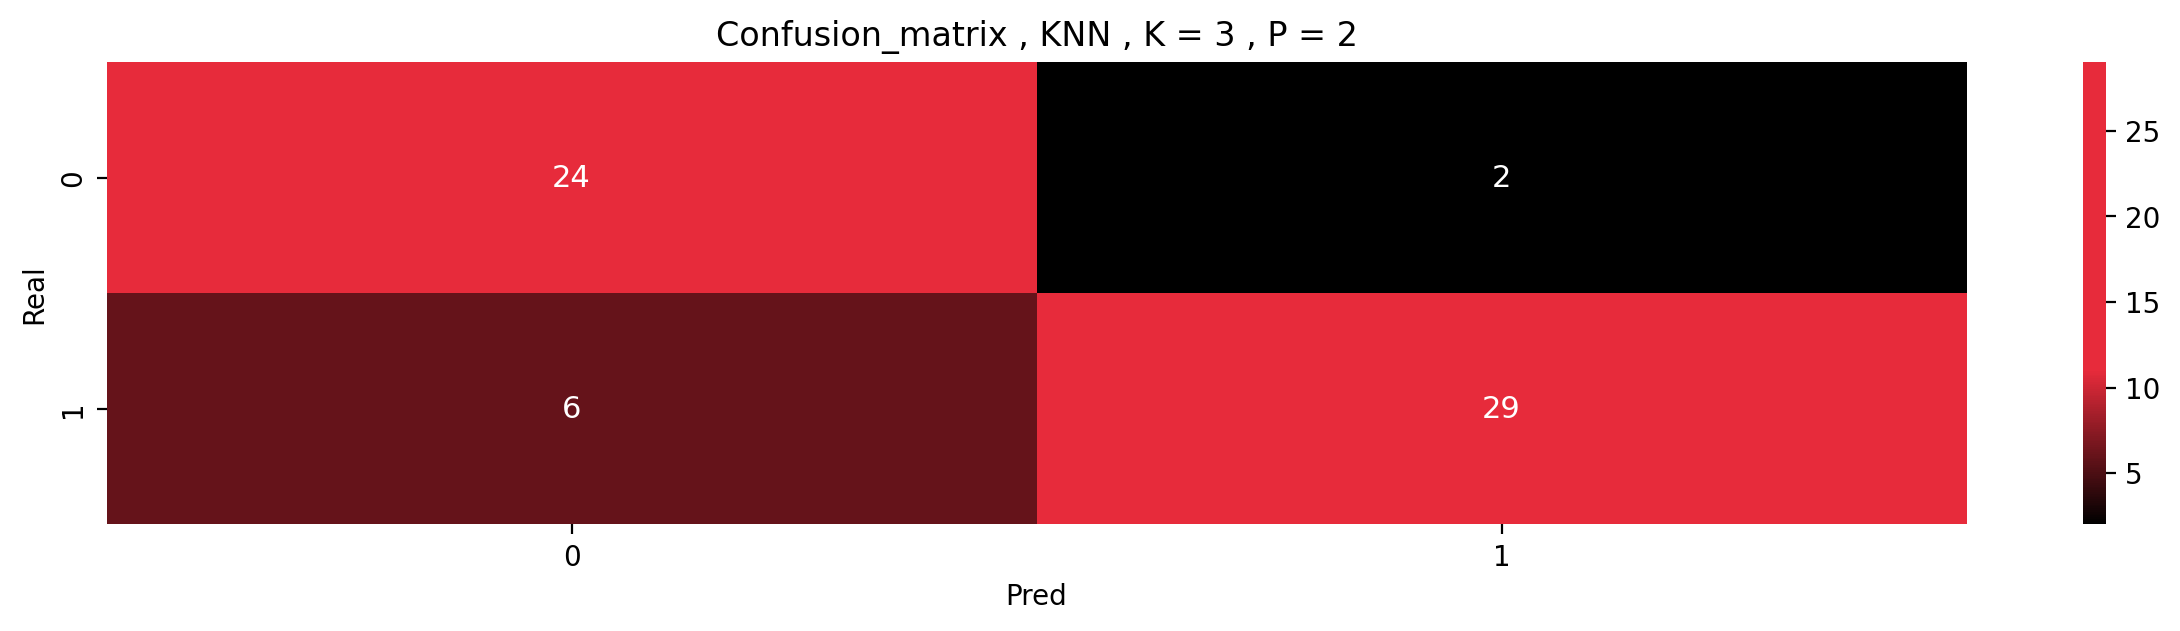

In [ ]:
conf_matrix_2 = confusion_matrix(y_test, y_pred_2)

colors = ["black", "#E72B3B", "#E72B3B", "#E72B3B"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig = plt.figure(figsize=(15, 3), dpi=200)
ax = plt.subplot()
plt.title("Confusion_matrix , KNN , K = 3 , P = 2")
annot = np.array([[f"{conf_matrix_2[0, 0]}", f"{conf_matrix_2[0, 1]}"],
                  [f"{conf_matrix_2[1, 0]}", f"{conf_matrix_2[1, 1]}"]], dtype=object)

sns.heatmap(conf_matrix_2,
            annot=annot,
            annot_kws={"size": 11},
            ax=ax,
            fmt='',
            cmap=cmap,
            cbar=True,
            )
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

In [ ]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [ ]:
print(Back.RED +color.BOLD+ "Classification report for clf_1 (K= 3 and p = 1):"+ Back.RESET+ color.END)
print(classification_report(y_train, clf_1.predict(X_train)))
print(Back.RED +color.BOLD +"Classification report for clf_2 (K= 3 and p = 2):"+ Back.RESET+ color.END)
print(classification_report(y_train, clf_2.predict(X_train)))

Classification report for clf_1 (K= 3 and p = 1):
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       112
           1       0.86      0.93      0.90       129

    accuracy                           0.88       241
   macro avg       0.89      0.88      0.88       241
weighted avg       0.89      0.88      0.88       241

Classification report for clf_2 (K= 3 and p = 2):
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       112
           1       0.86      0.91      0.88       129

    accuracy                           0.87       241
   macro avg       0.87      0.87      0.87       241
weighted avg       0.87      0.87      0.87       241



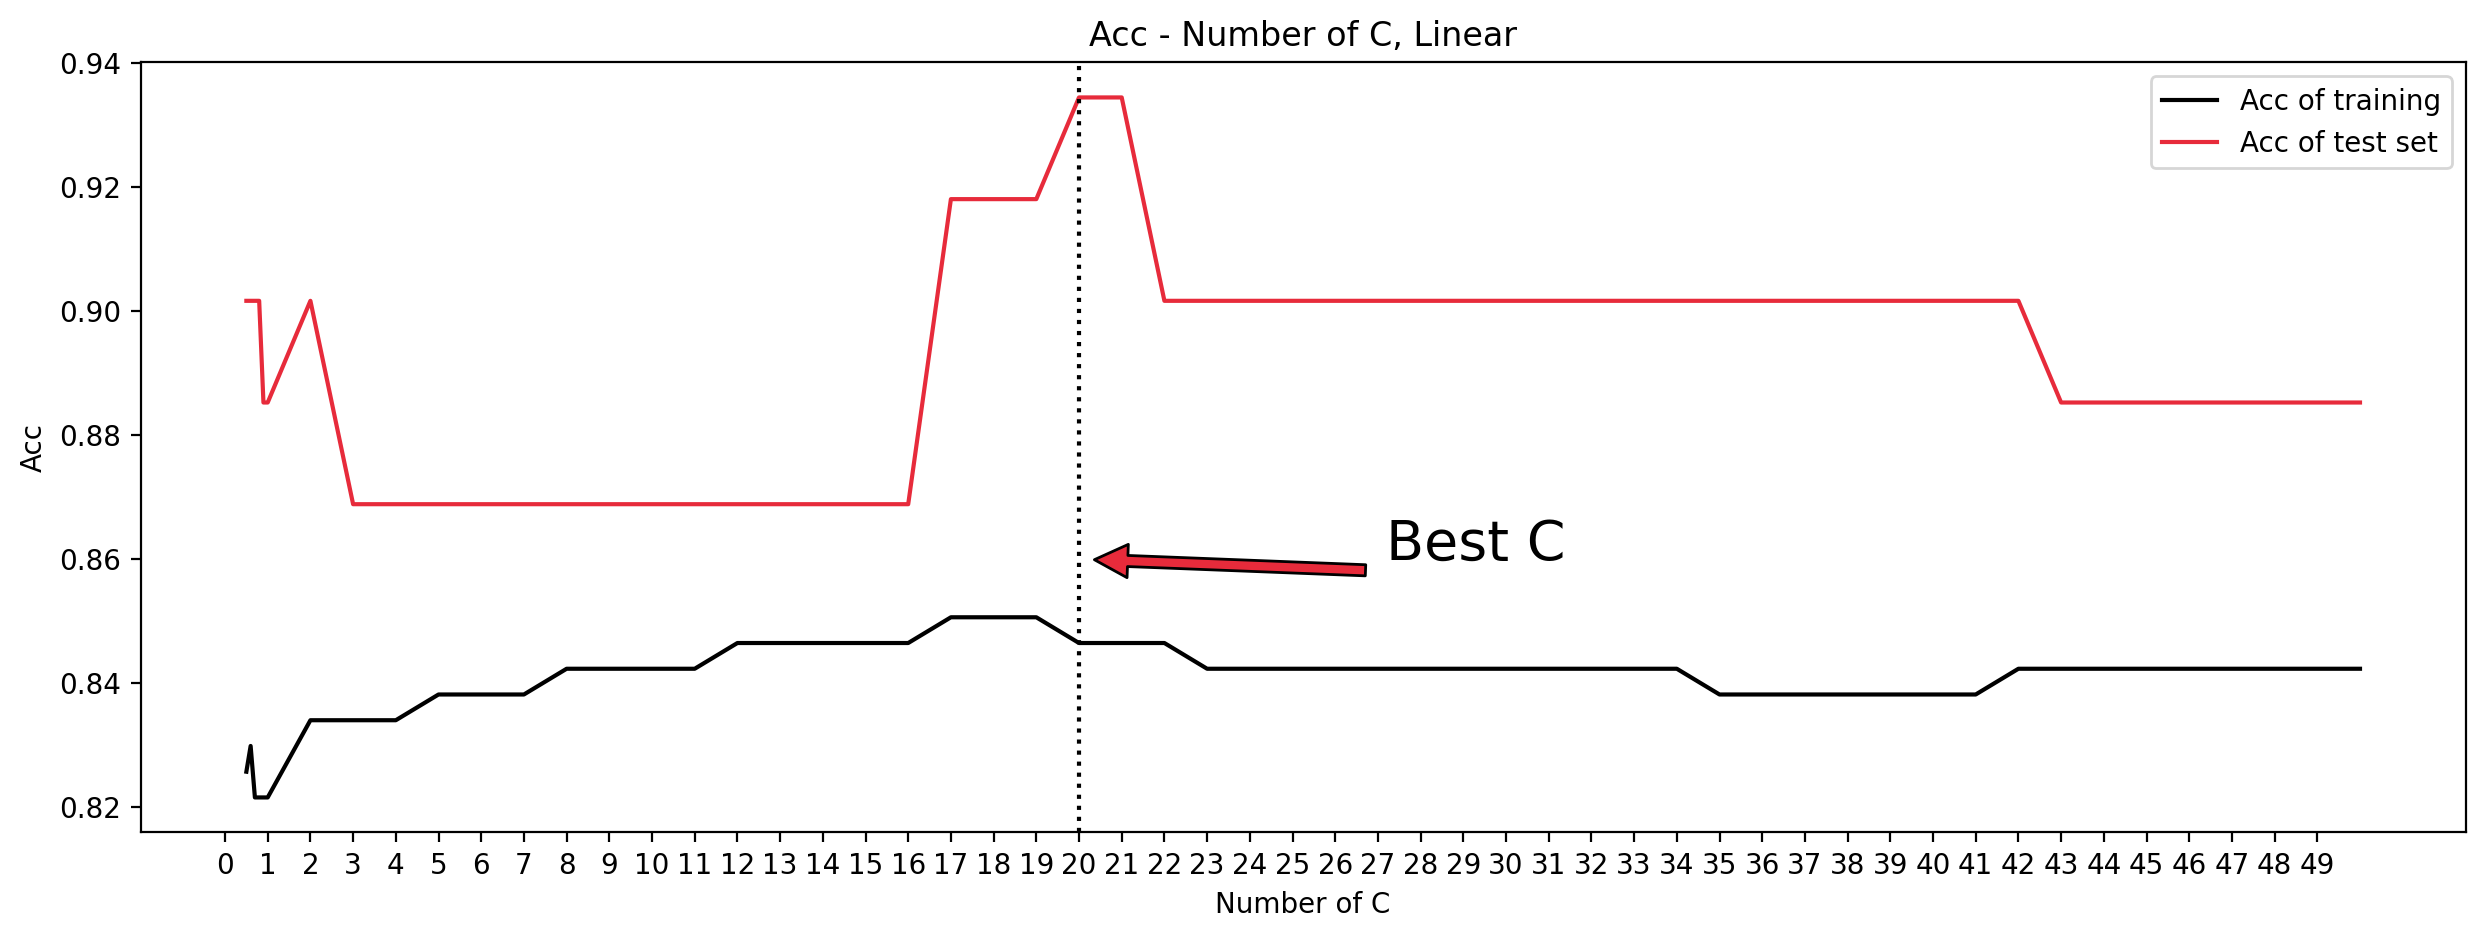

In [ ]:
training_acc_3 = []
test_acc_3 = []

C = [0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
    26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
#Kernel = {'linear', 'poly', 'rbf', 'sigmoid'}

for C_ in C:
    SVM = SVC(C= C_, kernel= 'linear')
    SVM.fit (X_train, y_train.ravel())
    training_acc_3.append(SVM.score(X_train,y_train))
    test_acc_3.append(SVM.score(X_test, y_test))


plt.figure(figsize=(15,5), dpi=200)
plt.plot(C, training_acc_3, label='Acc of training', color= 'black')
plt.plot(C, test_acc_3, label='Acc of test set', color= '#E72B3B')
plt.ylabel('Acc')
plt.xlabel('Number of C')
plt.title('Acc - Number of C, Linear')
plt.legend()
plt.xticks(range(0,50))
plt.annotate('Best C', xy=(20,0.86),xytext=(27.2,0.86), arrowprops=dict(facecolor='#E72B3B', shrink=0.05),fontsize=20)
plt.axvline(x = 20, linestyle= 'dotted', c= 'black')
plt.show()

In [ ]:
clf_3 = SVC(C= 20, kernel= 'linear')
clf_3.fit(X_train, y_train.ravel())
y_pred_3 = clf_3.predict(X_test)
print("Accuracy", metrics.accuracy_score(y_test,y_pred_3))
Best_SVM = metrics.accuracy_score(y_test,y_pred_3)

Accuracy 0.9344262295081968


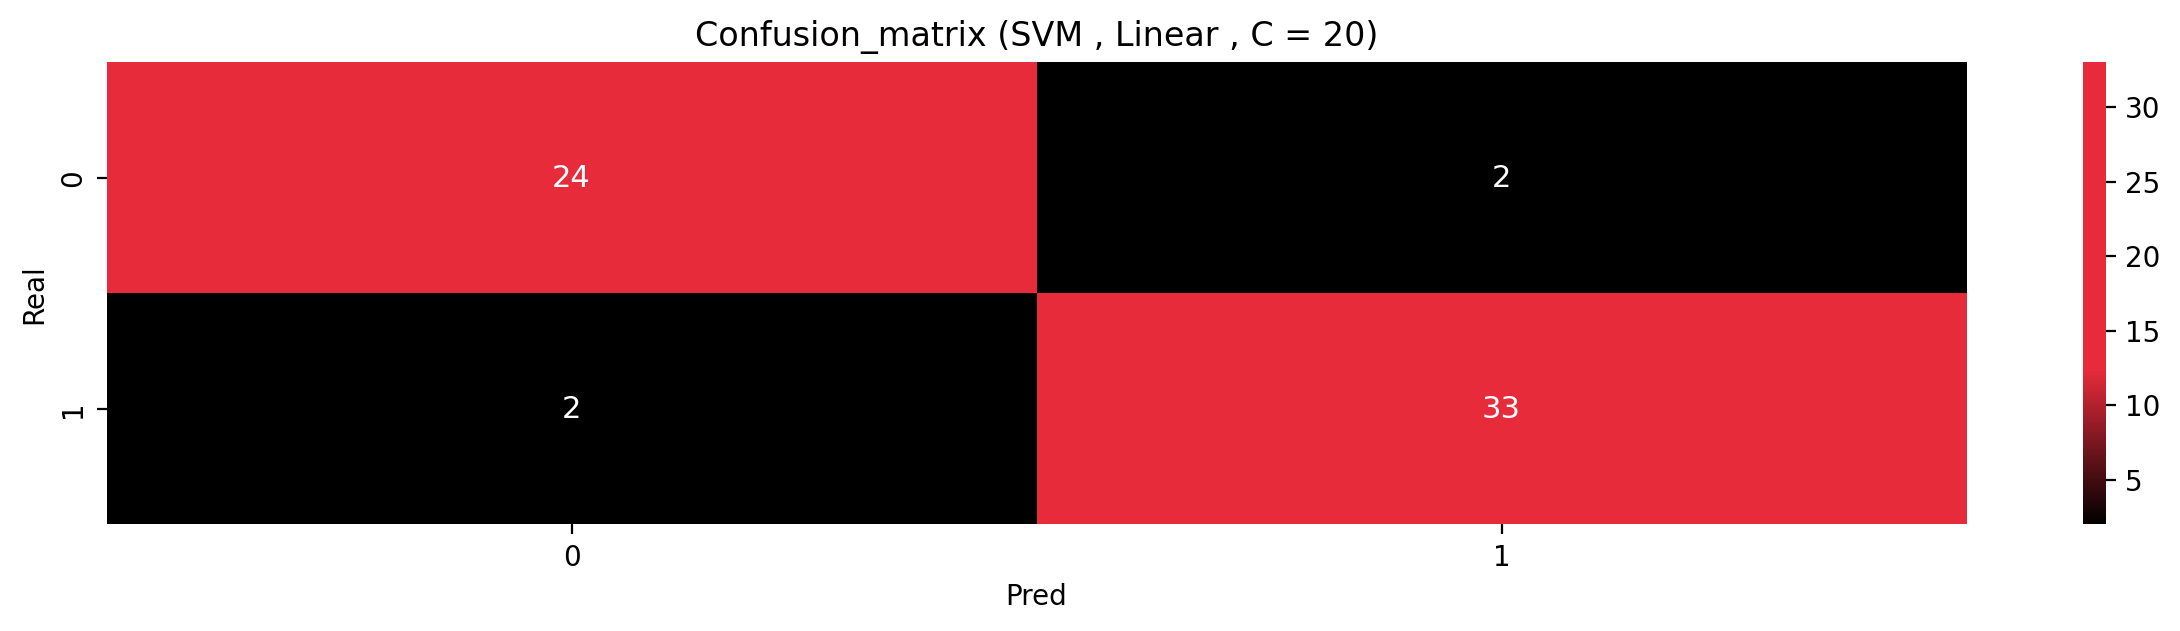

In [ ]:
conf_matrix_3 = confusion_matrix(y_test, y_pred_3)

colors = ["black", "#E72B3B", "#E72B3B", "#E72B3B"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig = plt.figure(figsize=(15, 3), dpi=200)
ax = plt.subplot()
plt.title("Confusion_matrix (SVM , Linear , C = 20)")
annot = np.array([[f"{conf_matrix_3[0, 0]}", f"{conf_matrix_3[0, 1]}"],
                  [f"{conf_matrix_3[1, 0]}", f"{conf_matrix_3[1, 1]}"]], dtype=object)

sns.heatmap(conf_matrix_3,
            annot=annot,
            annot_kws={"size": 11},
            ax=ax,
            fmt='',
            cmap=cmap,
            cbar=True,
            )
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

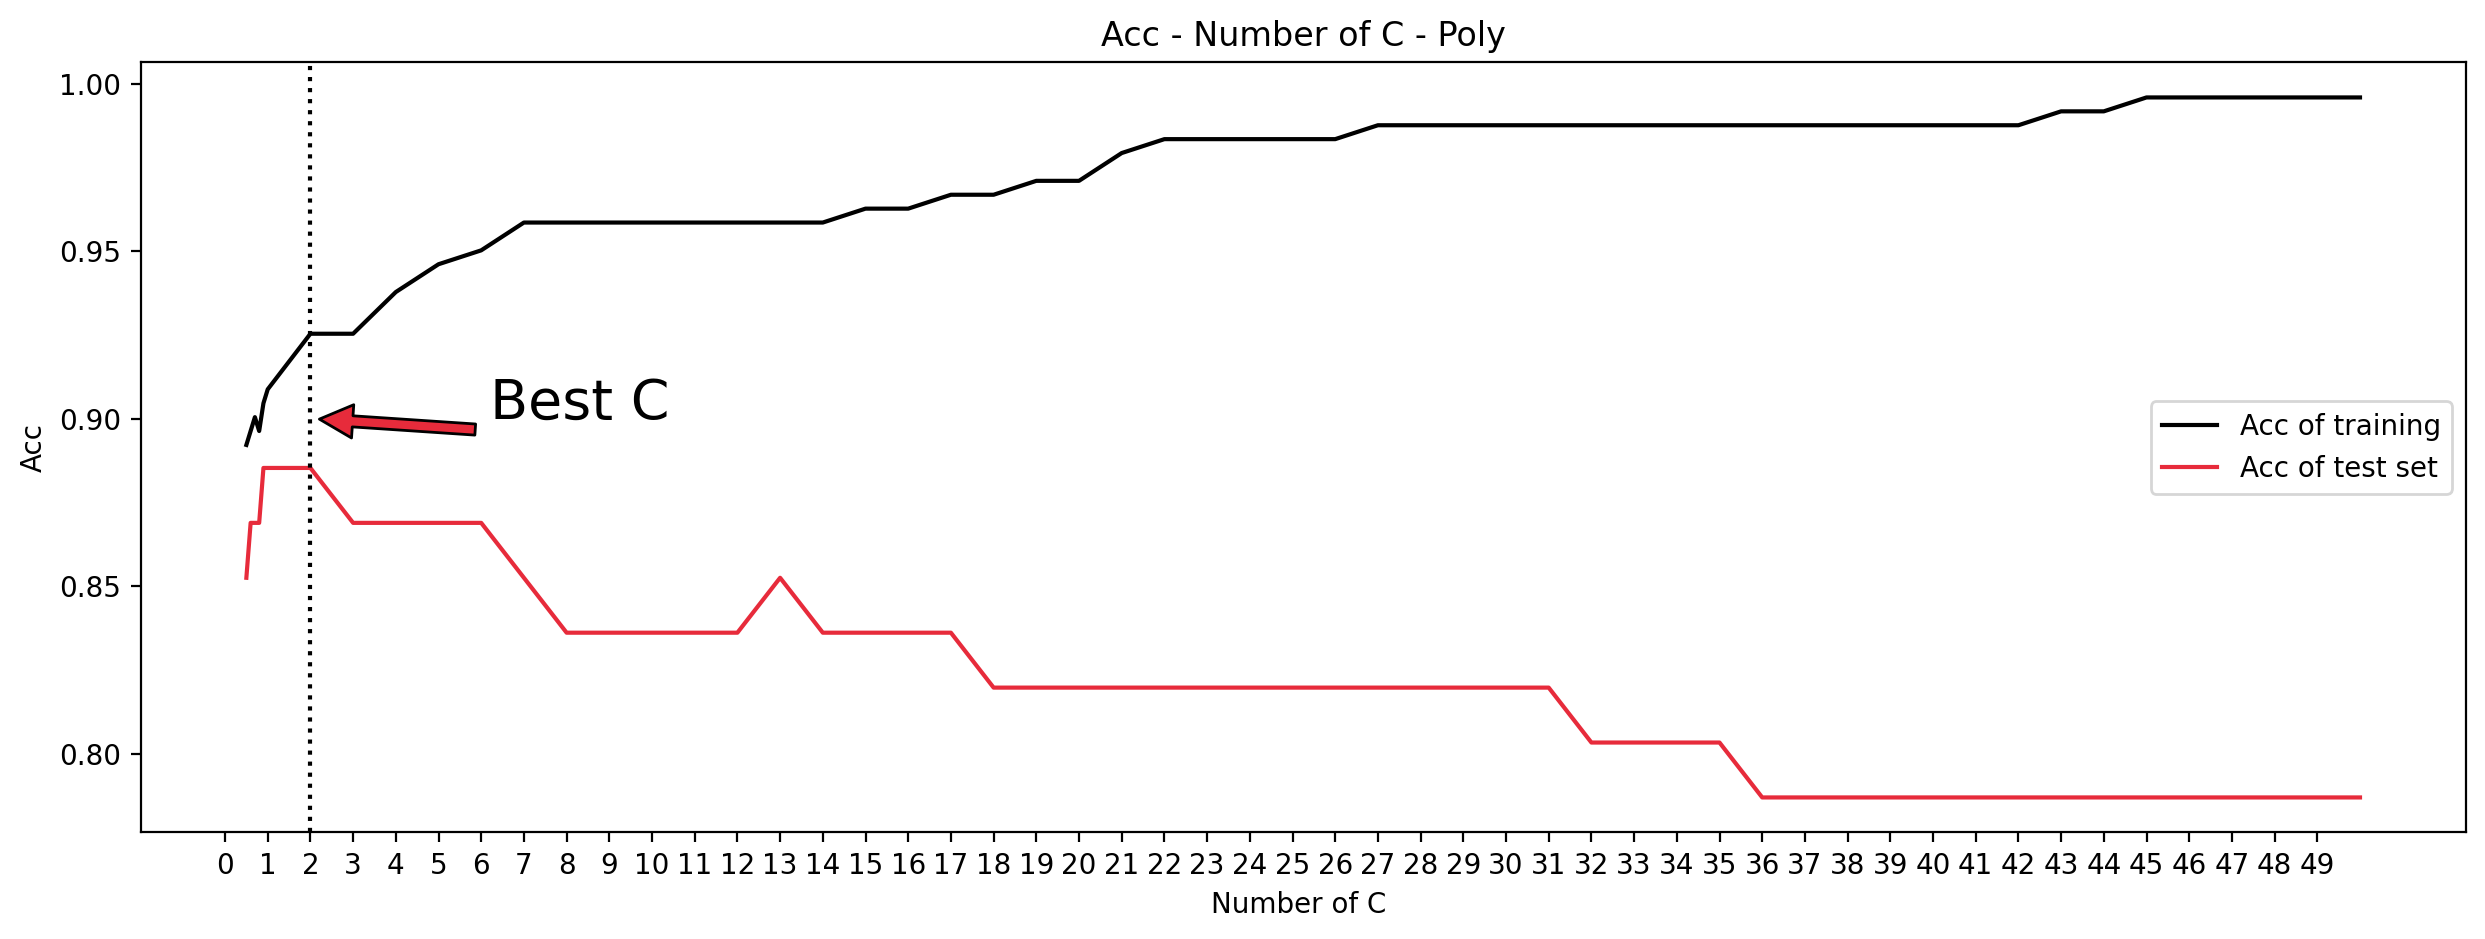

In [ ]:
training_acc_4 = []
test_acc_4 = []

C = [0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
    26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
#Kernel = {'linear', 'poly', 'rbf', 'sigmoid'}

for C_ in C:
    SVM = SVC(C= C_, kernel= 'poly')
    SVM.fit (X_train, y_train.ravel())
    training_acc_4.append(SVM.score(X_train,y_train))
    test_acc_4.append(SVM.score(X_test, y_test))


plt.figure(figsize=(15,5), dpi=200)
plt.plot(C, training_acc_4, label='Acc of training', color= 'black')
plt.plot(C, test_acc_4, label='Acc of test set', color= '#E72B3B')
plt.ylabel('Acc')
plt.xlabel('Number of C ')
plt.title('Acc - Number of C - Poly')
plt.legend()
plt.xticks(range(0,50))
plt.annotate('Best C', xy=(2,0.9),xytext=(6.2,0.9), arrowprops=dict(facecolor='#E72B3B', shrink=0.05),fontsize=20)
plt.axvline(x = 2, linestyle= 'dotted', c= 'black')
plt.show()

In [ ]:
clf_4 = SVC(C= 2, kernel= 'poly')
clf_4.fit(X_train, y_train.ravel())
y_pred_4 = clf_4.predict(X_test)
print("Accuracy", metrics.accuracy_score(y_test,y_pred_4))

Accuracy 0.8852459016393442


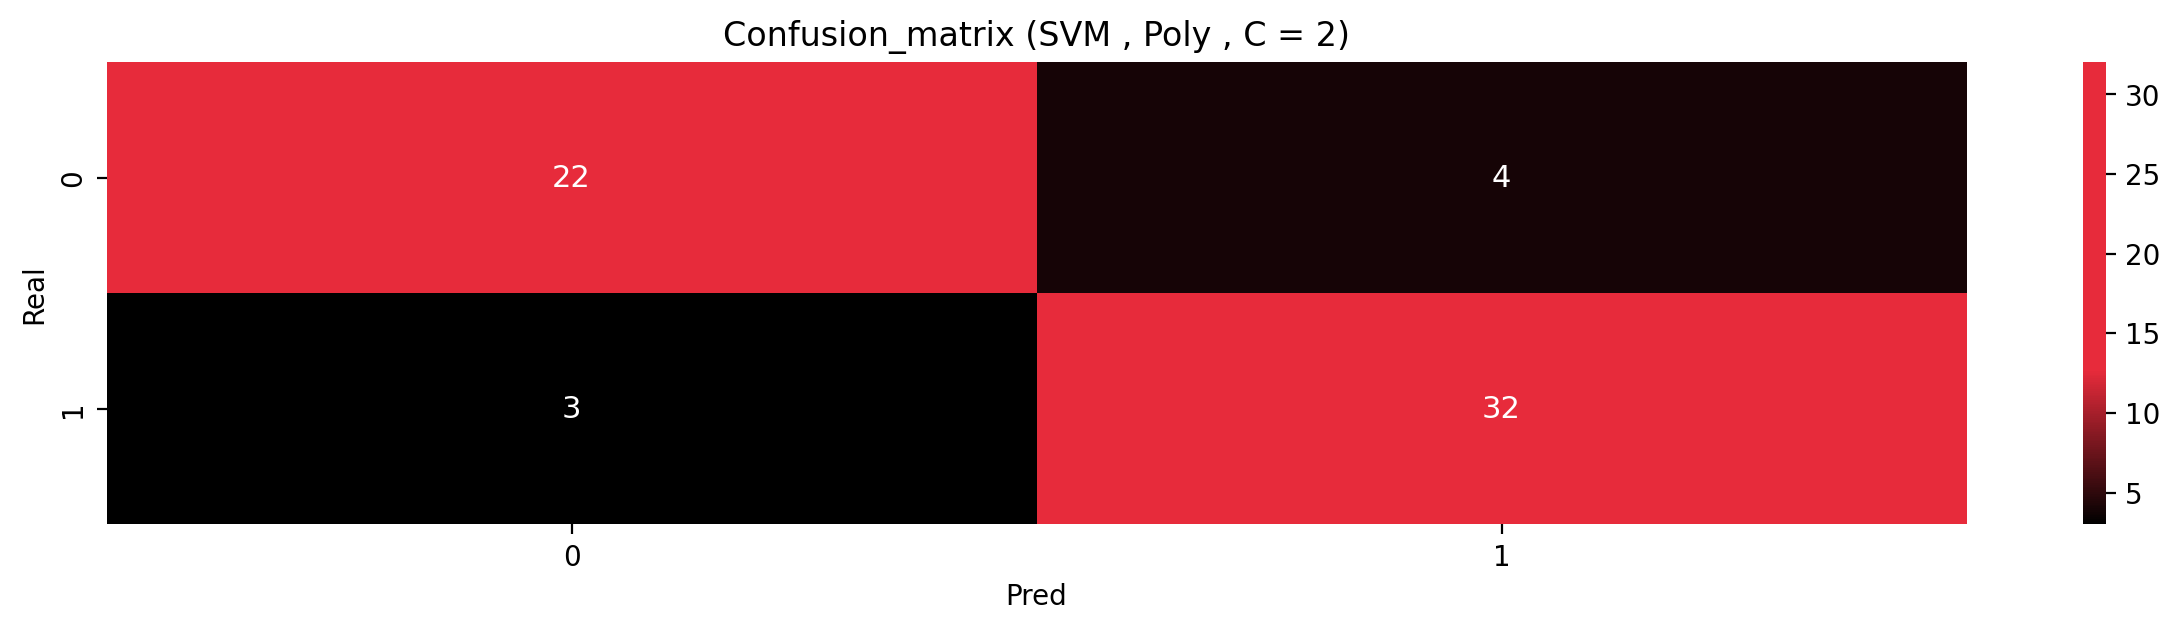

In [ ]:
conf_matrix_4 = confusion_matrix(y_test, y_pred_4)

colors = ["black", "#E72B3B", "#E72B3B", "#E72B3B"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig = plt.figure(figsize=(15, 3), dpi=200)
ax = plt.subplot()
plt.title("Confusion_matrix (SVM , Poly , C = 2)")
annot = np.array([[f"{conf_matrix_4[0, 0]}", f"{conf_matrix_4[0, 1]}"],
                  [f"{conf_matrix_4[1, 0]}", f"{conf_matrix_4[1, 1]}"]], dtype=object)

sns.heatmap(conf_matrix_4,
            annot=annot,
            annot_kws={"size": 11},
            ax=ax,
            fmt='',
            cmap=cmap,
            cbar=True,
            )
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

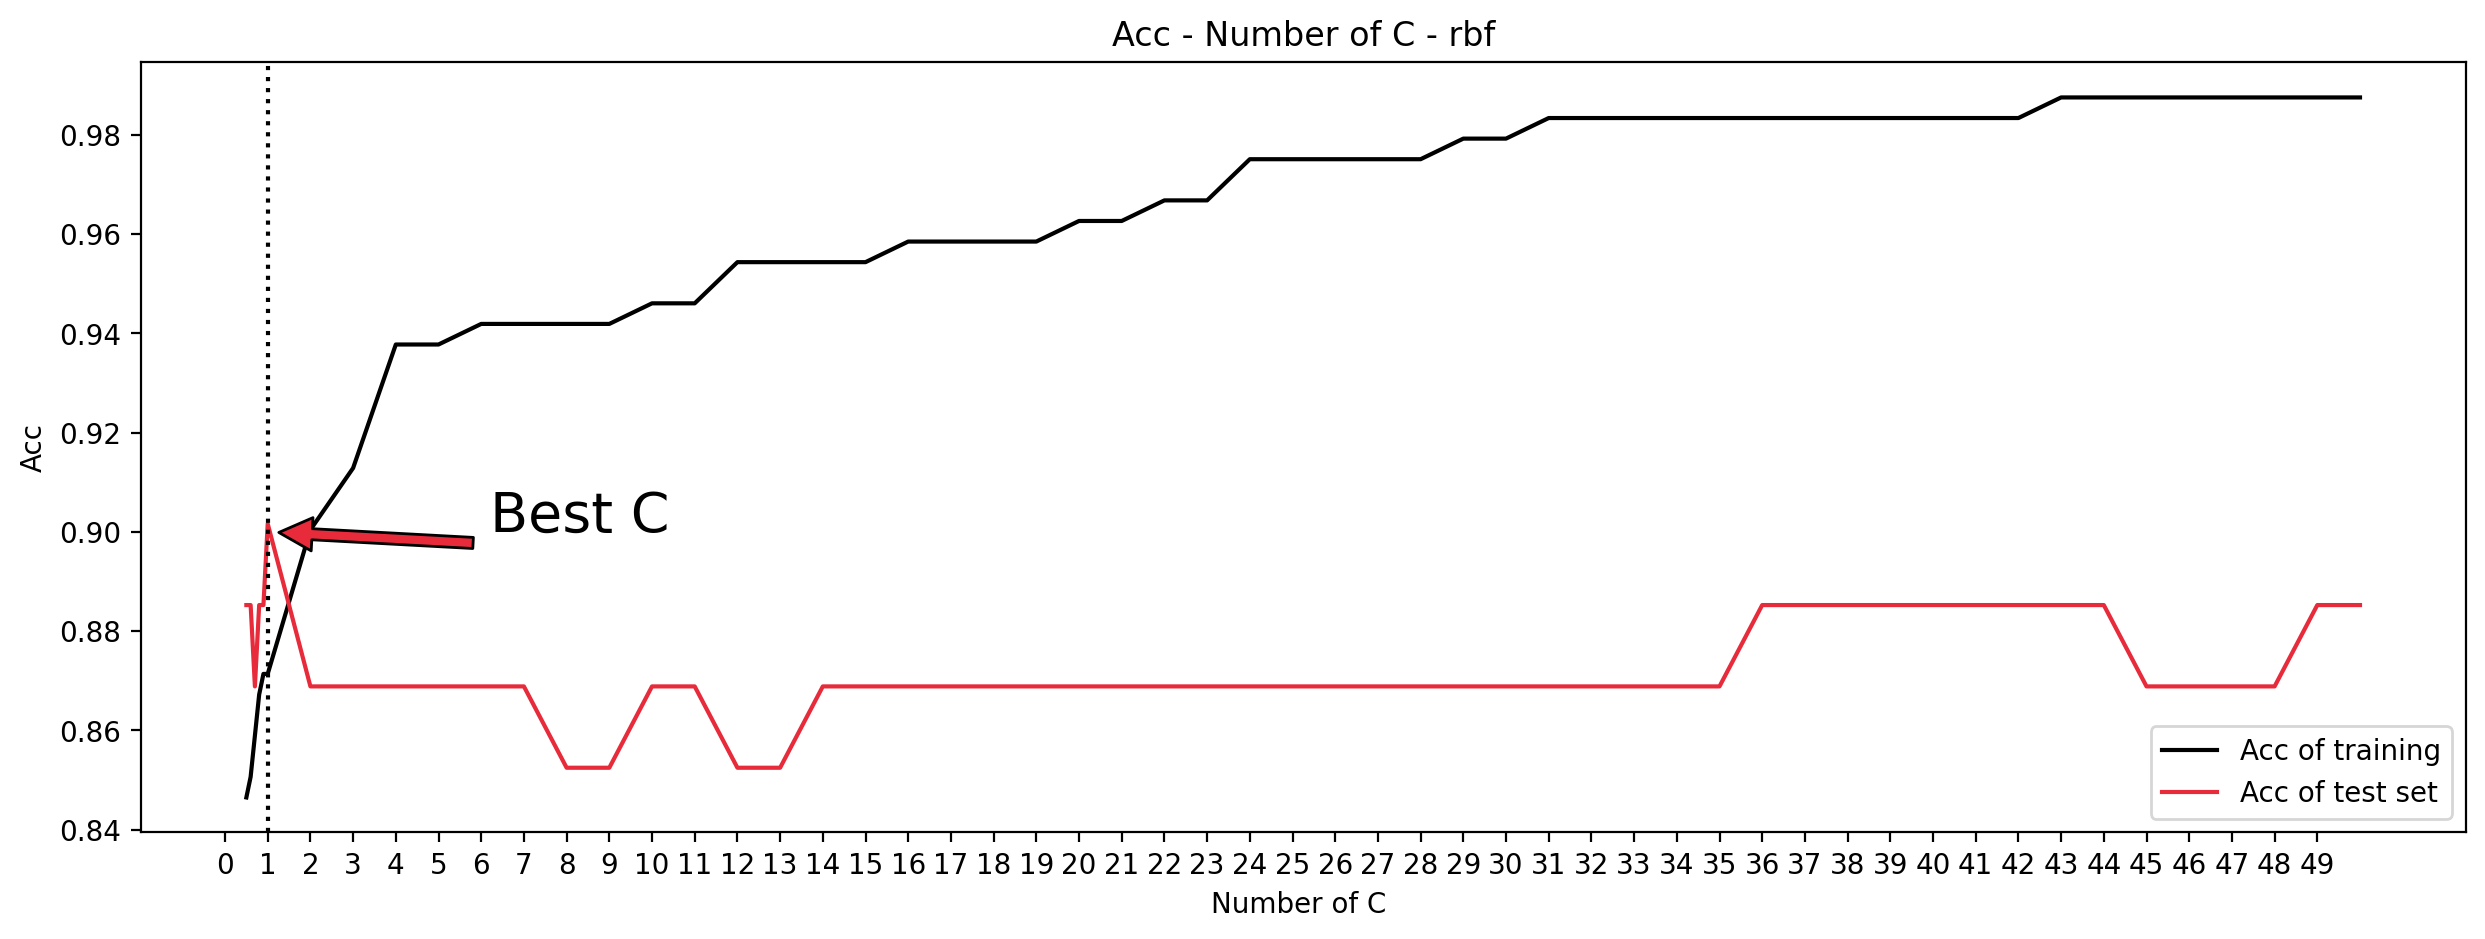

In [ ]:
training_acc_5 = []
test_acc_5 = []

C = [0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
    26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
#Kernel = {'linear', 'poly', 'rbf', 'sigmoid'}

for C_ in C:
    SVM = SVC(C= C_, kernel= 'rbf')
    SVM.fit (X_train, y_train.ravel())
    training_acc_5.append(SVM.score(X_train,y_train))
    test_acc_5.append(SVM.score(X_test, y_test))


plt.figure(figsize=(15,5), dpi=200)
plt.plot(C, training_acc_5, label='Acc of training', color= 'black')
plt.plot(C, test_acc_5, label='Acc of test set', color= '#E72B3B')
plt.ylabel('Acc')
plt.xlabel('Number of C ')
plt.title('Acc - Number of C - rbf')
plt.legend()
plt.xticks(range(0,50))
plt.annotate('Best C', xy=(1,0.9),xytext=(6.2,0.9), arrowprops=dict(facecolor='#E72B3B', shrink=0.05),fontsize=20)
plt.axvline(x = 1, linestyle= 'dotted', c= 'black')
plt.show()

In [ ]:
clf_5 = SVC(C= 1, kernel= 'rbf')
clf_5.fit(X_train, y_train.ravel())
y_pred_5 = clf_5.predict(X_test)
print("Accuracy", metrics.accuracy_score(y_test,y_pred_5))

Accuracy 0.9016393442622951


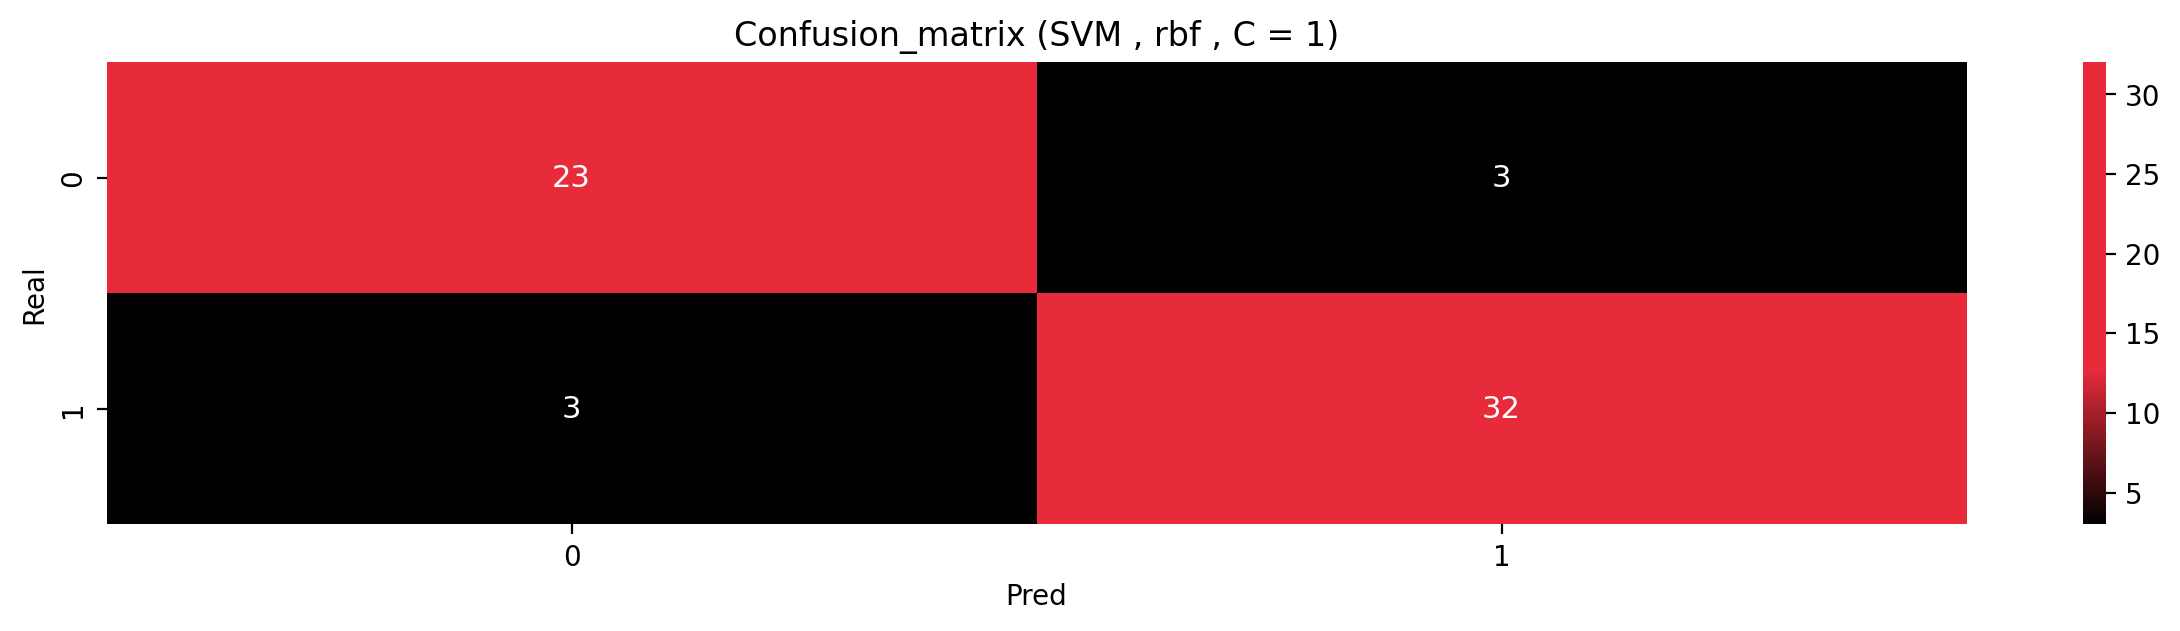

In [ ]:
conf_matrix_5 = confusion_matrix(y_test, y_pred_5)

colors = ["black", "#E72B3B", "#E72B3B", "#E72B3B"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig = plt.figure(figsize=(15, 3), dpi=200)
ax = plt.subplot()
plt.title("Confusion_matrix (SVM , rbf , C = 1)")
annot = np.array([[f"{conf_matrix_5[0, 0]}", f"{conf_matrix_5[0, 1]}"],
                  [f"{conf_matrix_5[1, 0]}", f"{conf_matrix_5[1, 1]}"]], dtype=object)

sns.heatmap(conf_matrix_5,
            annot=annot,
            annot_kws={"size": 11},
            ax=ax,
            fmt='',
            cmap=cmap,
            cbar=True,
            )
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

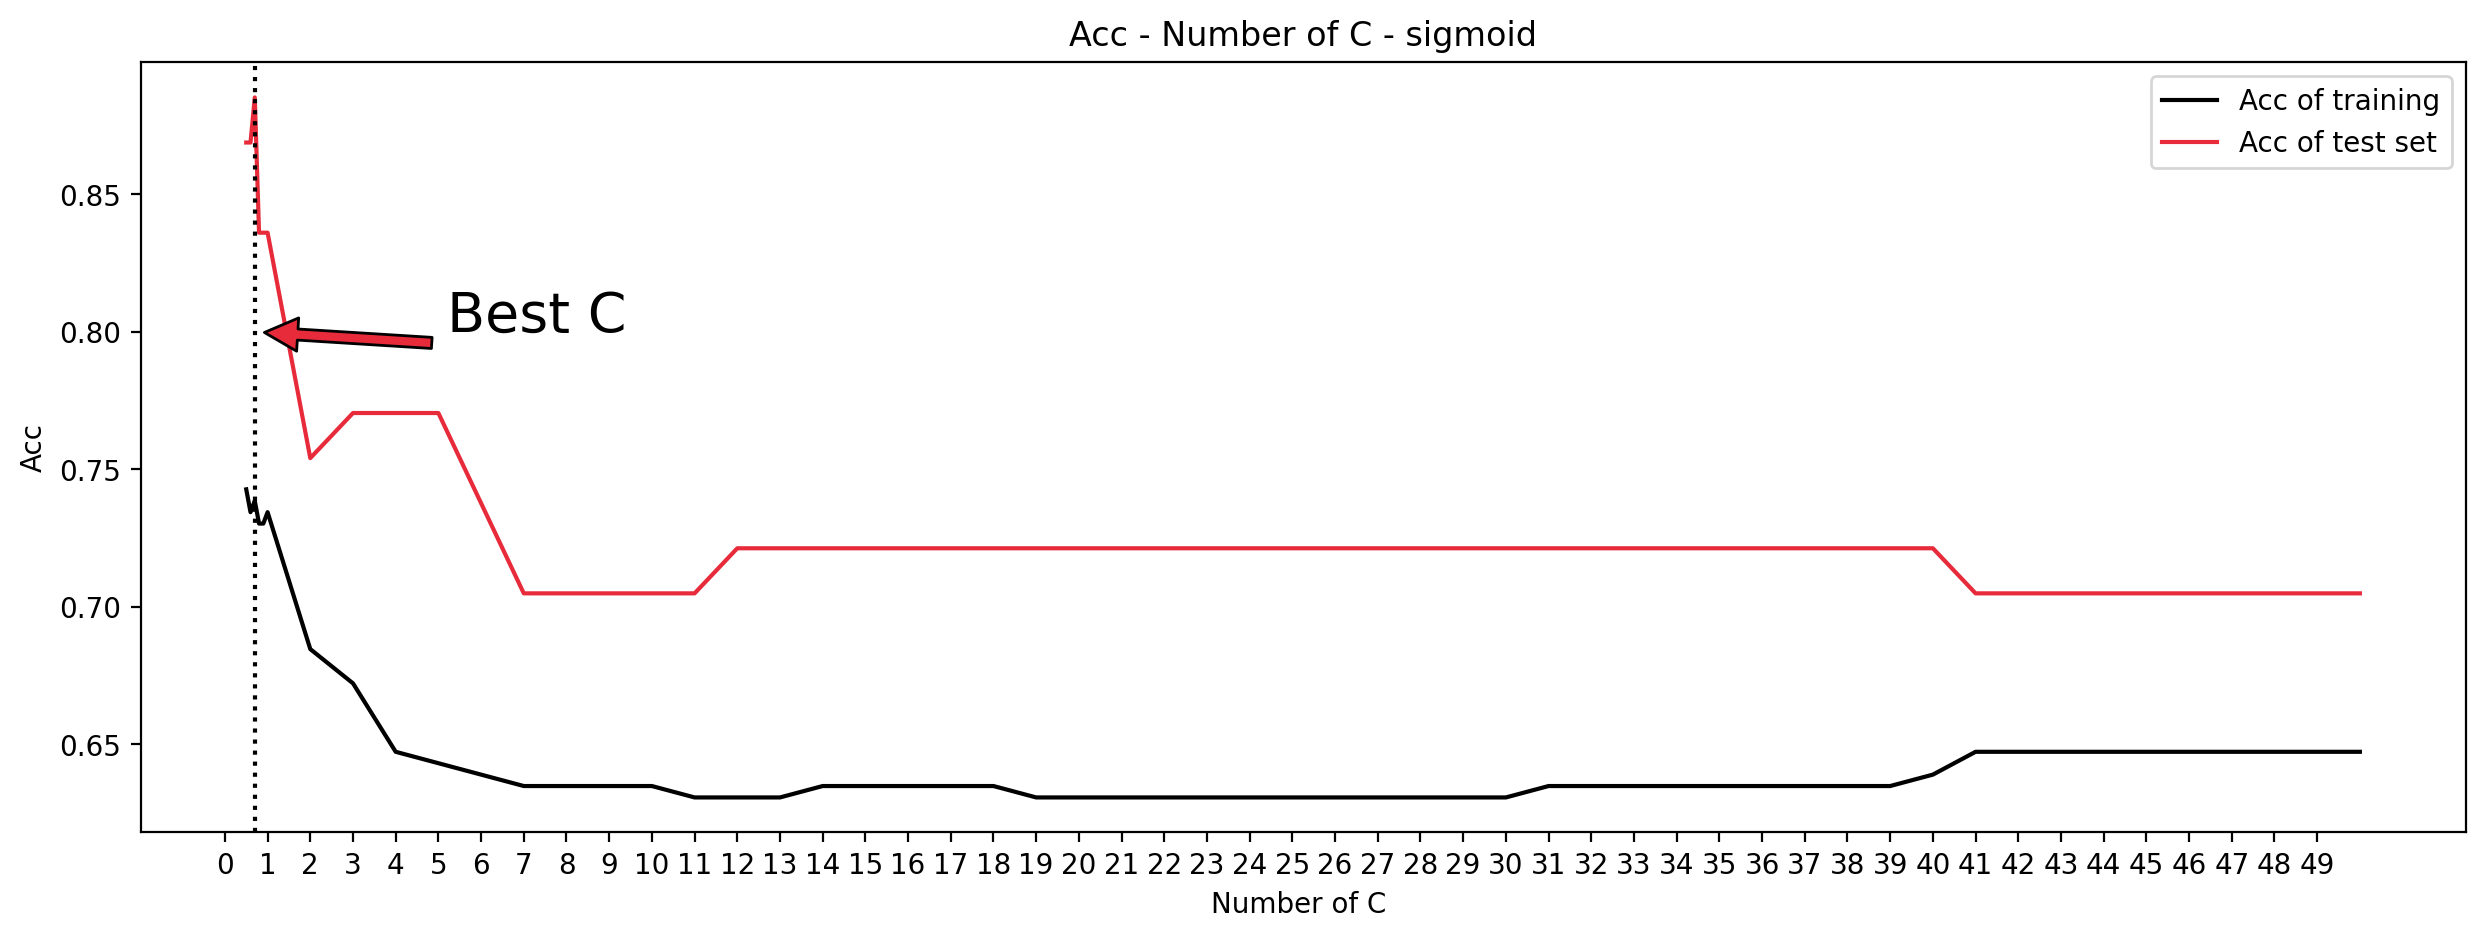

In [ ]:
training_acc_6 = []
test_acc_6 = []

C = [0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
    26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]
#Kernel = {'linear', 'poly', 'rbf', 'sigmoid'}

for C_ in C:
    SVM = SVC(C= C_, kernel= 'sigmoid')
    SVM.fit (X_train, y_train.ravel())
    training_acc_6.append(SVM.score(X_train,y_train))
    test_acc_6.append(SVM.score(X_test, y_test))


plt.figure(figsize=(15,5), dpi=200)
plt.plot(C, training_acc_6, label='Acc of training', color= 'black')
plt.plot(C, test_acc_6, label='Acc of test set', color= '#E72B3B')
plt.ylabel('Acc')
plt.xlabel('Number of C ')
plt.title('Acc - Number of C - sigmoid')
plt.legend()
plt.xticks(range(0,50))
plt.annotate('Best C', xy=(0.7,0.8),xytext=(5.2,0.8), arrowprops=dict(facecolor='#E72B3B', shrink=0.05),fontsize=20)
plt.axvline(x =0.7, linestyle= 'dotted', c= 'black')
plt.show()

In [ ]:
clf_6 = SVC(C= 0.7, kernel= 'sigmoid')
clf_6.fit(X_train, y_train.ravel())
y_pred_6 = clf_6.predict(X_test)
print("Accuracy", metrics.accuracy_score(y_test,y_pred_6))

Accuracy 0.8852459016393442


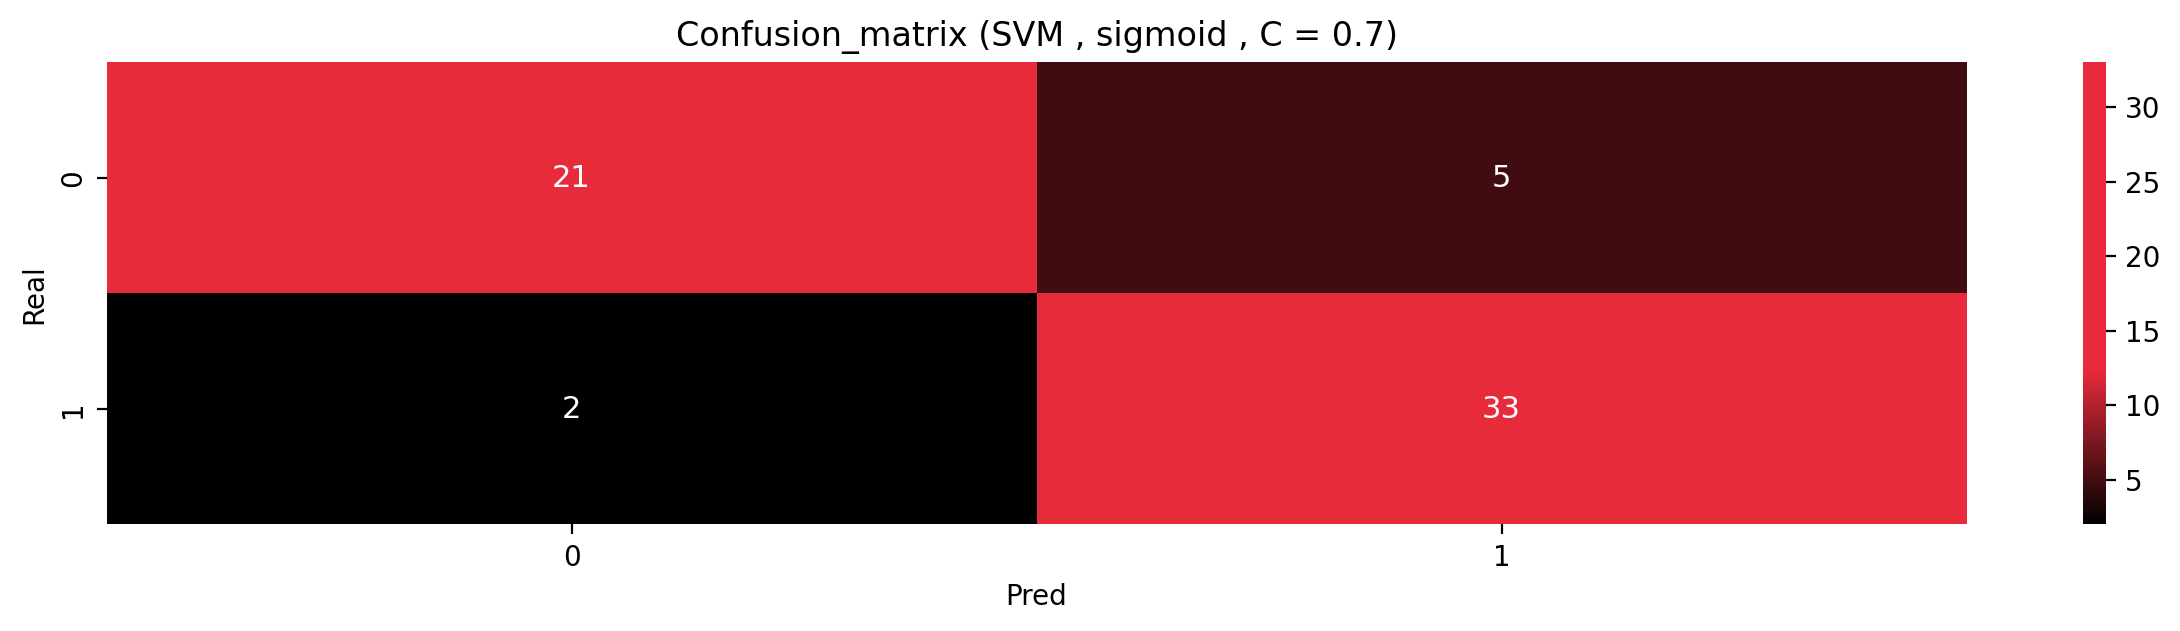

In [ ]:
conf_matrix_6 = confusion_matrix(y_test, y_pred_6)

colors = ["black", "#E72B3B", "#E72B3B", "#E72B3B"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
fig = plt.figure(figsize=(15, 3), dpi=200)
ax = plt.subplot()
plt.title("Confusion_matrix (SVM , sigmoid , C = 0.7)")
annot = np.array([[f"{conf_matrix_6[0, 0]}", f"{conf_matrix_6[0, 1]}"],
                  [f"{conf_matrix_6[1, 0]}", f"{conf_matrix_6[1, 1]}"]], dtype=object)

sns.heatmap(conf_matrix_6,
            annot=annot,
            annot_kws={"size": 11},
            ax=ax,
            fmt='',
            cmap=cmap,
            cbar=True,
            )
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()